<a href="https://colab.research.google.com/github/bgorai005/deeplearning_assignment1/blob/main/dl_assign1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# Name-Biswajit gorai ,Roll no- MA24M005

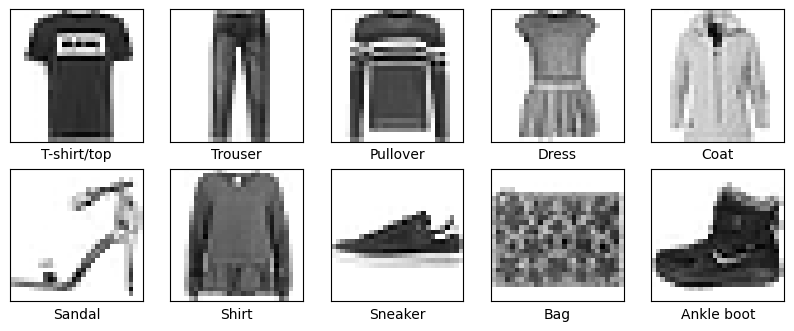

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import wandb

# Login to Weights & Biases
wandb.login()

# Initialize W&B project
wandb.init(project='deep_learning_assignment_1',name='dataset_samples',mode='online')

# Load the Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Define the class labels
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
wandb.log({"examples":[wandb.Image(train_images[i],caption=class_labels[train_labels[i]])for i in range(10)]})
# Plot 1 sample image for each class
plt.figure(figsize=(10, 10))
for label in range(10):
    sample_image = train_images[train_labels == label][0]
    plt.subplot(5, 5, label + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(class_labels[label])
    plt.imshow(sample_image, cmap=plt.cm.binary)
plt.show()

# Finish the W&B run
wandb.finish()
#594642013968a68e466138e783dcece6765c43b9

In [20]:
from sklearn.model_selection import train_test_split

def tranform_dataset(train_images,train_labels,test_images,test_labels):
  #split the training dataset for traning and validation
  x_train,x_valid,y_train,y_valid=train_test_split(train_images,train_labels,test_size=0.1,random_state=42)
   #flattenten the image data
  x_train = x_train.reshape(x_train.shape[0], -1)
  x_valid = x_valid.reshape(x_valid.shape[0], -1)
  x_test = test_images.reshape(test_images.shape[0], -1)
  #Normalize the image data
  x_train = x_train.astype('float32') / 255
  x_valid = x_valid.astype('float32') / 255
  x_test = x_test.astype('float32') / 255
  # one hot encode for output column
  y_train = one_hot_encode(y_train)
  y_valid = one_hot_encode(y_valid)
  y_test = one_hot_encode(test_labels)


  return x_train,y_train,x_valid,y_valid,x_test,y_test



#one hot encoding for output
def one_hot_encode(labels):
    encoded = np.zeros((len(labels), 10))
    for i, label in enumerate(labels):
        encoded[i, label] = 1
    return encoded


In [21]:
#transform the dataset for using the feedforward neural network models
x_train,y_train,x_valid,y_valid,x_test,y_test=tranform_dataset(train_images,train_labels,test_images,test_labels)

In [22]:
#shapes of the datasets
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_valid shape:", x_valid.shape)
print("y_valid shape:", y_valid.shape)

x_train shape: (54000, 784)
y_train shape: (54000, 10)
x_valid shape: (6000, 784)
y_valid shape: (6000, 10)


Intialize a network

In [23]:
import numpy as np

def initial_weight(num_layer, hidden_size, weight_ini_method):
    # Create a list with num_layer hidden layers, each of size hidden_size
    network_size = [hidden_size] * num_layer
    # Prepend input size and append output size
    network_size = [x_train.shape[1]] + network_size + [y_train.shape[1]]
    print(network_size)  # Print the network architecture for debugging

    # Initialize an empty dictionary to store weights and biases
    theta = {}

    # Random initialization
    if weight_ini_method == "random":
        for i in range(len(network_size) - 1):
            # Weights: shape (current layer size, next layer size)
            theta[f'W{i+1}'] = np.random.randn(network_size[i], network_size[i+1])
            # Biases: shape (1, next layer size)
            theta[f'b{i+1}'] = np.random.randn(1, network_size[i+1])

    # Xavier (He-like) initialization
    elif weight_ini_method == "Xavier":
        for i in range(len(network_size) - 1):
            # Scaling factor based on input size (fan-in)
            scale = np.sqrt(2 / network_size[i])
            # Weights: random normal scaled by sqrt(2 / fan-in)
            theta[f'W{i+1}'] = np.random.randn(network_size[i], network_size[i+1]) * scale
            # Biases: random normal scaled by sqrt(2 / fan-in)
            theta[f'b{i+1}'] = np.random.randn(1, network_size[i+1]) * scale

    # Return the initialized parameters
    return theta

*Activation functiont**

In [24]:
def sigmoid(x):
  return 1 /(1 + np.exp(-x))

def relu(x):
  return np.maximum(0, x)

def tanh(x):
	return np.tanh(x)

def deriv_sigmoid(x):
  return sigmoid(x)*(1-sigmoid(x))

def deriv_relu(x):
  return np.where(x <= 0, 0, 1)

def deriv_tanh(x):
  return (1 - (tanh(x))**2)

def softmax(x):
  x = x - np.max(x,axis=1,keepdims=True)
  return np.exp(x)/np.sum(np.exp(x),axis=1,keepdims=True)




def activation(x, activ_fun):
  if activ_fun == 'sigmoid':
    return sigmoid(x)
  elif activ_fun == 'relu':
    return relu(x)
  elif activ_fun=='softmax':
    return softmax(x)
  else:
    return tanh(x)

def deriv_activation(x, activ_fun):
  if activ_fun == 'sigmoid':
    return deriv_sigmoid(x)
  elif activ_fun == 'relu':
    return deriv_relu(x)
  else:
    return deriv_tanh(x)


Loss function

In [25]:
def cross_entropy(y_actual, y_pred):
   epsilon = 1e-15  # to prevent log(0) which is undefined
   y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
   loss = -np.mean(np.sum(y_actual * np.log(y_pred), axis=1))
   return loss
def mse_loss(y_actual,y_pred):
  return np.mean((y_actual-y_pred)**2)


def deriv_cross_entropy(y_actual,y_pred):
    return (y_pred-y_actual)

def deriv_mse_loss(y_actual,y_pred):
    return ((y_pred - y_actual) - ((y_pred - y_actual) * y_pred).sum(axis=0)) * y_pred

def loss_derivative(y_actual,y_pred,loss_function):
  if loss_function=='cross_entropy':
    return deriv_cross_entropy
  else:
    return deriv_mse_loss



In [26]:
def forward_prop(X, theta, active_fun_hidden, active_fun_output, num_layers):

  a = {}
  h = {'h0': X}
  for i in range(1, num_layers + 1):
    a[f'a{i}'] = np.dot(h[f'h{i-1}'], theta[f'W{i}']) + theta[f'b{i}']
    h[f'h{i}'] = activation(a[f'a{i}'], active_fun_hidden)
  a[f'a{num_layers+1}'] = np.dot(h[f'h{num_layers}'], theta[f'W{num_layers+1}']) + theta[f'b{num_layers+1}']
  y_pred = activation(a[f'a{num_layers+1}'], active_fun_output)
  return a, h, y_pred


In [9]:
# theta=initial_weight(5,[5]*5,"random")
# _,_,y_pred=forward_prop(x_train,theta,"sigmoid",'softmax',5)
# print(y_pred)

Calculate accuracy

In [27]:
def cal_accuracy(x,y,theta,active_fun_hidden,active_fun_output,num_layers):
    # Get the input size from X (number of features)
    input_size = x.shape[0]

    # Perform forward propagation to get predicted probabilities
    # We only need y_pred, so ignore other returned values with _
    _, _, y_pred = forward_prop(x, theta,
                               active_fun_hidden,active_fun_output,num_layers)

    # Get true class labels from one-hot encoded Y (index of 1 in each column)
    true_classes = np.argmax(y, axis=1)

    # Get predicted class labels from y_pred (index of max probability in each column)
    predicted_classes = np.argmax(y_pred, axis=1)

    # Calculate accuracy as the proportion of correct predictions
    accuracy = np.mean(predicted_classes == true_classes)

    return accuracy

Back_prop

In [28]:
def back_prop(x,y,theta,active_fun_hidden,active_fun_output,num_layers):
  m=x.shape[0]
  a,h,y_pred=forward_prop(x,theta,active_fun_hidden,active_fun_output,num_layers)
  grad_theta={}
  grad_h_a={}
  # Compute loss derivative
  grad_h_a[f'a{num_layers+1}'] = y_pred - y
  for i in range(num_layers+1,0,-1):
    grad_theta[f'W{i}']=np.dot(h[f'h{i-1}'].T,grad_h_a[f'a{i}'])
    grad_theta[f'b{i}']=np.sum(grad_h_a[f'a{i}'],axis=0,keepdims=True)

    if i>1:
      grad_h_a[f'h{i-1}']=np.dot(grad_h_a[f'a{i}'],theta[f'W{i}'].T)
      grad_h_a[f'a{i-1}']=grad_h_a[f'h{i-1}']*deriv_activation(a[f'a{i-1}'],active_fun_hidden)
  return grad_theta

Now we again write gradient decesent algorithm compatiable with batch size ,

In [29]:
def sgd(lr, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    # Initialize weights
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)
    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        # Mini-batch training
        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients and update weights
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers)
            for j in range(1, num_layers + 2):
                theta[f'W{j}'] -= lr * (grad[f'W{j}'] + weight_decay * theta[f'W{j}'])
                theta[f'b{j}'] -= lr * grad[f'b{j}']
        # Compute the train accuracy
        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store training loss
        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        train_loss_history.append(train_loss)

        # Compute the validation accuracy
        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_accuracy": train_accuracy * 100, "val_accuracy": validation_accuracy * 100, 'epoch': epoch + 1})



    return theta, train_loss_history, val_loss_history


Moment Gradient descent (here momentum=beta)

In [30]:
def mgd(lr, momentum, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)
    train_loss_history = []
    val_loss_history = []

    # Initialize velocity terms for weights and biases
    velocity = {}
    for i in range(1, num_layers + 2):
        velocity[f'W{i}'] = np.zeros_like(theta[f'W{i}'])
        velocity[f'b{i}'] = np.zeros_like(theta[f'b{i}'])

    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        # Mini-batch training
        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers)

            # Update weights and biases using momentum
            for j in range(1, num_layers + 2):
                velocity[f'W{j}'] = momentum * velocity[f'W{j}'] + grad[f'W{j}']
                velocity[f'b{j}'] = momentum * velocity[f'b{j}'] + grad[f'b{j}']

                theta[f'W{j}'] -= lr * (velocity[f'W{j}'] + weight_decay * theta[f'W{j}'])
                theta[f'b{j}'] -= lr * velocity[f'b{j}']

        # Compute the train accuracy
        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store training loss
        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        train_loss_history.append(train_loss)

        # Compute the validation accuracy
        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_accuracy": train_accuracy * 100, "val_accuracy": validation_accuracy * 100, 'epoch': epoch + 1})



    return theta


**Nesterov accelerated gradient descent**

In [31]:
def nesterov_gd(lr, momentum, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entorpy'):
    # Initialize network parameters
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)

    # Initialize velocity dictionary with zeros, matching the shape of each parameter
    velocity = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    # List to store loss history
    loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Look ahead step for Nesterov momentum
            lookahead_theta = {key: theta[key] - momentum * velocity[key] for key in theta.keys()}

            # Compute gradients using backpropagation on the lookahead parameters
            grad = back_prop(x_batch, y_batch, lookahead_theta, active_fun_hidden, active_fun_output, num_layers)

            # Update velocities and parameters with Nesterov momentum and apply weight decay
            for k in range(1, num_layers + 2):
                # Update velocity for weights
                velocity[f'W{k}'] = momentum * velocity[f'W{k}'] + grad[f'W{k}'] + weight_decay * theta[f'W{k}']
                # Update weights using velocity
                theta[f'W{k}'] -= lr * velocity[f'W{k}']

                # Update velocity for biases
                velocity[f'b{k}'] = momentum * velocity[f'b{k}'] + grad[f'b{k}']
                # Update biases using velocity (no weight decay for biases)
                theta[f'b{k}'] -= lr * velocity[f'b{k}']

        # Compute the train accuracy
        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute training loss and predictions
        a, h, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        loss_history.append(train_loss)

        # Compute the validation accuracy
        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        # Print loss for monitoring
        print(f"Epoch {epoch+1}, Loss: {train_loss}, Validation Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_accuracy": train_accuracy * 100, "val_accuracy": validation_accuracy * 100,'epoch':epoch+1})

    return theta

**RMS Prop**

In [32]:
def rmsprop(lr, gamma, epsilon, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    # Initialize network parameters
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)

    # Initialize squared gradient dictionary with zeros
    squared_grad = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    # Lists to store loss history
    loss_history = []
    val_loss_history = []

    # Training loop over epochs
    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients using backpropagation
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers)

            # Update squared gradients and parameters using RMSprop
            for k in range(1, num_layers + 2):
                # Update squared gradient for weights
                squared_grad[f'W{k}'] = gamma * squared_grad[f'W{k}'] + (1 - gamma) * (grad[f'W{k}'] ** 2)
                # Apply weight decay separately (L2 Regularization)
                theta[f'W{k}'] -= lr * (grad[f'W{k}'] / (np.sqrt(squared_grad[f'W{k}']) + epsilon)) + weight_decay * theta[f'W{k}']

                # Update squared gradient for biases
                squared_grad[f'b{k}'] = gamma * squared_grad[f'b{k}'] + (1 - gamma) * (grad[f'b{k}'] ** 2)
                # Update biases
                theta[f'b{k}'] -= lr * (grad[f'b{k}'] / (np.sqrt(squared_grad[f'b{k}']) + epsilon))

        # Compute training accuracy
        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute training loss
        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        loss_history.append(train_loss)

        # Compute validation accuracy
        val_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        # Print loss for monitoring
        print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.2%}, Val Acc: {val_accuracy:.2%}")

        # Log metrics to W&B
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_accuracy": train_accuracy * 100,
            "val_accuracy": val_accuracy * 100
        })

    return theta


**ADAM**

In [33]:
def adam(lr, beta1, beta2, epsilon, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)
    train_loss_history = []
    val_loss_history = []

    # Initialize first moment (m) and second moment (v) dictionaries with zeros
    m = {key: np.zeros_like(theta[key]) for key in theta.keys()}
    v = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    for epoch in range(1, epochs + 1):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients using backpropagation
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers)

            # Update first and second moment estimates and parameters with Adam
            for k in range(1, num_layers + 2):
                m[f'W{k}'] = beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']
                m[f'b{k}'] = beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']

                v[f'W{k}'] = beta2 * v[f'W{k}'] + (1 - beta2) * (grad[f'W{k}'] ** 2)
                v[f'b{k}'] = beta2 * v[f'b{k}'] + (1 - beta2) * (grad[f'b{k}'] ** 2)

                m_hat_W = m[f'W{k}'] / (1 - beta1 ** epoch)
                m_hat_b = m[f'b{k}'] / (1 - beta1 ** epoch)
                v_hat_W = v[f'W{k}'] / (1 - beta2 ** epoch)
                v_hat_b = v[f'b{k}'] / (1 - beta2 ** epoch)

                theta[f'W{k}'] -= lr * (m_hat_W / (np.sqrt(v_hat_W) + epsilon) + weight_decay * theta[f'W{k}'])
                theta[f'b{k}'] -= lr * m_hat_b / (np.sqrt(v_hat_b) + epsilon)

        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        train_loss_history.append(train_loss)

        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_accuracy": train_accuracy * 100, "val_accuracy": validation_accuracy * 100, 'epoch': epoch})

    return theta


**NDAM**

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def nadam(lr, beta1, beta2, epsilon, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    # Initialize network parameters
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)

    # Initialize first moment (m) and second moment (v) dictionaries with zeros
    m = {key: np.zeros_like(theta[key]) for key in theta.keys()}
    v = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    # Lists to store loss history
    loss_history = []
    val_loss_history = []

    # Training loop over epochs
    for epoch in range(1, epochs + 1):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train, y_train = x_train[indices], y_train[indices]

        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients using backpropagation
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers)

            # Update first and second moment estimates and parameters with Nadam
            for k in range(1, num_layers + 2):
                # Update biased first moment estimate
                m[f'W{k}'] = beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']
                m[f'b{k}'] = beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']

                # Update biased second moment estimate
                v[f'W{k}'] = beta2 * v[f'W{k}'] + (1 - beta2) * (grad[f'W{k}'] ** 2)
                v[f'b{k}'] = beta2 * v[f'b{k}'] + (1 - beta2) * (grad[f'b{k}'] ** 2)

                # Compute bias-corrected first and second moment estimates with Nesterov acceleration
                m_hat_W = (beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']) / (1 - beta1 ** epoch)
                m_hat_b = (beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']) / (1 - beta1 ** epoch)
                v_hat_W = v[f'W{k}'] / (1 - beta2 ** epoch)
                v_hat_b = v[f'b{k}'] / (1 - beta2 ** epoch)

                # Update weights and biases
                theta[f'W{k}'] -= lr * (m_hat_W / (np.sqrt(v_hat_W) + epsilon) + weight_decay * theta[f'W{k}'])
                theta[f'b{k}'] -= lr * m_hat_b / (np.sqrt(v_hat_b) + epsilon)

        # Compute training accuracy
        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute training loss
        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        loss_history.append(train_loss)

        # Compute validation accuracy
        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        # Print loss for monitoring
        print(f"Epoch {epoch}, Loss: {train_loss}, Validation Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_accuracy": train_accuracy * 100, "val_accuracy": validation_accuracy * 100, 'epoch': epoch})

    return theta


**MOdel **

In [35]:
def model_training(lr, beta, beta1, beta2, epsilon, x_train, y_train, x_valid, y_valid, optimizer, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function):

    if optimizer == 'sgd':
        theta = sgd(lr, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entopy')
    elif optimizer == 'momentum':
        theta = mgd(lr, beta, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entopy')
    elif optimizer == 'nag':
        theta = nesterov_gd(lr, beta, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entopy')
    elif optimizer == 'RMSprop':
        theta = rmsprop(lr, beta, epsilon, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entopy')
    elif optimizer == 'adam':
        theta = adam(lr, beta1, beta2, epsilon, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entopy')
    elif optimizer=='nadam':
      theta=nadam(lr, beta1, beta2, epsilon, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entopy')
    return theta

In [19]:
#Q2 and Q3 train a neural network with given hypermaters with cross entropy loss
#in question 2 intialize a neural network and pass a forward prop that will predict probabilities. here i run adam model , in there first it create
#a intial network and call backprop update weights , in back prop at first it will call forward prop then update weights and it will iterate as many epochs it has
#and give the accuracy, loss for train and valid dataset.
#---------uncomment the below code for run----------------
#wandb.init(project='deep_learning_assignment_1',name='adam-relu-softmax-random-layer-4-hid_size-32-epoch-5'')
#theta=adam(0.001,0.9,0.99,1e-8,x_train, y_train, x_valid, y_valid,32,4,'relu','softmax','random',0,5)
#wandb.finish()


In [36]:
sweep_config={
    'method':'bayes',#possible search random,grid
    'metric':{
        'name':'Valdiation_accuracy',
        'goal':'maximize'
    },
    'parameters':{
        'epochs':{
            'values':[5,10]

        },
      'hidden_size':{
            'values':[32, 64, 128]
        },
        'activation_hidden':{
            'values':['relu','sigmoid','tanh']
        },
        'activation_output':{
            'values':['softmax']
        },
        'weight_ini_method':{
            'values':['Xavier','random']
        },
        'batch_size':{
            'values':[16,32,64]
        }
      ,'num_layers':{
            'values':[3,4,5]
        },
        'weight_decay':{
            'values':[0]#(we take l2 regulraization as zero)
        } ,
        'learning_rate':{
            'values':[1e-3,1e-4]
      }
        ,'optimizer':{
            'values':['sgd','momentum','nag','RMSprop','adam','nadam']
}
    }
}
sweep_id=wandb.sweep(sweep_config,project='deep_learning_assignment_1')

Create sweep with ID: bul7tp7h
Sweep URL: https://wandb.ai/bgorai005-iit-madras/deep_learning_assignment_1/sweeps/bul7tp7h


In [37]:
def main():
  with wandb.init() as run:
    run_name=f"ac-{wandb.config.activation_hidden}_hs-{wandb.config.hidden_size}_epc-{wandb.config.epochs}_nl-{wandb.config.num_layers}_lr{wandb.config.learning_rate}_wd-{wandb.config.weight_decay}_opt-{wandb.config.optimizer}_bs-{wandb.config.batch_size}_wi-{wandb.config.weight_ini_method}"
    wandb.run.name=run_name

    model_training(wandb.config.learning_rate,0.9,0.9,0.99,1e-8,x_train,y_train,x_valid,y_valid,wandb.config.optimizer,wandb.config.batch_size,wandb.config.num_layers,wandb.config.hidden_size,wandb.config.activation_hidden,wandb.config.activation_output,wandb.config.weight_ini_method,wandb.config.weight_decay,wandb.config.epochs,'cross_entropy')

try:
    wandb.agent(sweep_id,function=main,count=100)
    wandb.finish()
except BrokenPipeError:
    print("Encountered a BrokenPipeError. Attempting to gracefully finish the run.")
    # You can add additional error handling logic here, such as saving intermediate results
    wandb.finish(quiet=True)  # Try finishing quietly to avoid further errors

wandb: Agent Starting Run: 8eumdree with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.031176502201103466, Val Loss: 0.032101274074742905
Epoch 2, Train Loss: 0.02738649394021985, Val Loss: 0.028826792058522517
Epoch 3, Train Loss: 0.025939040617450646, Val Loss: 0.027418225128335465
Epoch 4, Train Loss: 0.023921522008831395, Val Loss: 0.025837761742605905
Epoch 5, Train Loss: 0.02286007664050695, Val Loss: 0.024870197279470835


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▄▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,83.71296
train_loss,0.02286
val_accuracy,82.2
val_loss,0.02487


wandb: Agent Starting Run: zapobigz with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.02216438770658351, Val Loss: 0.02308202547611097
Epoch 2, Train Loss: 0.016444692433939583, Val Loss: 0.017723065452883466
Epoch 3, Train Loss: 0.01566392441218536, Val Loss: 0.017940345743141763
Epoch 4, Train Loss: 0.014266556379230747, Val Loss: 0.01664769307503494
Epoch 5, Train Loss: 0.013807944119845188, Val Loss: 0.016664852143178564
Epoch 6, Train Loss: 0.013105200531734567, Val Loss: 0.016365709488894153
Epoch 7, Train Loss: 0.012184053788621352, Val Loss: 0.01604225529697175
Epoch 8, Train Loss: 0.012517225919629312, Val Loss: 0.016726505744762036
Epoch 9, Train Loss: 0.011309453434372464, Val Loss: 0.015911545572000866
Epoch 10, Train Loss: 0.010514736232685973, Val Loss: 0.01555379116010341


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▅▆▆▆▇▇▇█
train_loss,█▅▄▃▃▃▂▂▁▁
val_accuracy,▁▆▆▇▇▇█▇▇█
val_loss,█▃▃▂▂▂▁▂▁▁
epoch,10
train_accuracy,92.83704
train_loss,0.01051
val_accuracy,89.25
val_loss,0.01555


wandb: Agent Starting Run: hvrjqndh with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 10]
Epoch 1, Loss: 0.1226, Val Loss: 0.1229, Train Acc: 20.40%, Val Acc: 20.23%
Epoch 2, Loss: 0.1003, Val Loss: 0.1002, Train Acc: 31.03%, Val Acc: 30.42%
Epoch 3, Loss: 0.0843, Val Loss: 0.0847, Train Acc: 40.35%, Val Acc: 39.20%
Epoch 4, Loss: 0.0739, Val Loss: 0.0749, Train Acc: 46.41%, Val Acc: 45.45%
Epoch 5, Loss: 0.0673, Val Loss: 0.0689, Train Acc: 50.76%, Val Acc: 49.00%
Epoch 6, Loss: 0.0623, Val Loss: 0.0639, Train Acc: 54.25%, Val Acc: 52.88%
Epoch 7, Loss: 0.0590, Val Loss: 0.0606, Train Acc: 56.10%, Val Acc: 54.82%
Epoch 8, Loss: 0.0560, Val Loss: 0.0577, Train Acc: 58.12%, Val Acc: 56.67%
Epoch 9, Loss: 0.0538, Val Loss: 0.0558, Train Acc: 59.62%, Val Acc: 58.35%
Epoch 10, Loss: 0.0520, Val Loss: 0.0542, Train Acc: 60.58%, Val Acc: 59.32%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▆▆▇▇███
train_loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▃▄▆▆▇▇███
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,60.58148
train_loss,0.05204
val_accuracy,59.31667
val_loss,0.05422


wandb: Agent Starting Run: i1ocl9d7 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.12119581409961812, Val Loss: 0.12144700335828855
Epoch 2, Train Loss: 0.1065819604199076, Val Loss: 0.10793384588798034
Epoch 3, Train Loss: 0.09727079183993692, Val Loss: 0.0985298199220513
Epoch 4, Train Loss: 0.0907161589747689, Val Loss: 0.09153375623799434
Epoch 5, Train Loss: 0.08594100691673368, Val Loss: 0.08743636296743224


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▃▅▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,37.24815
train_loss,0.08594
val_accuracy,37.06667
val_loss,0.08744


wandb: Agent Starting Run: 3qnk23df with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.0458727208675424, Val Loss: 0.046993594074468396
Epoch 2, Train Loss: 0.039497953473729835, Val Loss: 0.040760304512660765
Epoch 3, Train Loss: 0.036446144707845345, Val Loss: 0.0376572983164802
Epoch 4, Train Loss: 0.034327262016414554, Val Loss: 0.03554656606939357
Epoch 5, Train Loss: 0.03292787471214728, Val Loss: 0.03422612520092182
Epoch 6, Train Loss: 0.03215306154992949, Val Loss: 0.03347076245624881
Epoch 7, Train Loss: 0.030942713603878957, Val Loss: 0.032133044557035674
Epoch 8, Train Loss: 0.029857959560332704, Val Loss: 0.031054223298731337
Epoch 9, Train Loss: 0.029498029206275322, Val Loss: 0.030932902236712034
Epoch 10, Train Loss: 0.028621785587750987, Val Loss: 0.02997935137589947


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▆▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▅▆▆▆▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,79.60741
train_loss,0.02862
val_accuracy,78.58333
val_loss,0.02998


wandb: Agent Starting Run: 84wk7e8p with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.021604946891312395, Val Loss: 0.022766348074825807
Epoch 2, Train Loss: 0.020000713499264102, Val Loss: 0.021520827328109067
Epoch 3, Train Loss: 0.019384534296454127, Val Loss: 0.020852256224148272
Epoch 4, Train Loss: 0.020176370872959124, Val Loss: 0.021637280374395093
Epoch 5, Train Loss: 0.017101924317945414, Val Loss: 0.019353831913764163
Epoch 6, Train Loss: 0.017237993622989483, Val Loss: 0.019337730089945528
Epoch 7, Train Loss: 0.017392465296555693, Val Loss: 0.020006469852081984
Epoch 8, Train Loss: 0.018349323778430057, Val Loss: 0.021111172539630872
Epoch 9, Train Loss: 0.017947925746748392, Val Loss: 0.02080108902373775
Epoch 10, Train Loss: 0.016396065307182447, Val Loss: 0.01904205095882429


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▄▂▇▇▆▅▆█
train_loss,█▆▅▆▂▂▂▄▃▁
val_accuracy,▁▄▄▃▇█▆▅▆█
val_loss,█▆▄▆▂▂▃▅▄▁
epoch,10
train_accuracy,88.55926
train_loss,0.0164
val_accuracy,86.75
val_loss,0.01904


wandb: Agent Starting Run: w4k1x203 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.05844341588338703, Val Loss: 0.0588618525056201
Epoch 2, Train Loss: 0.048668074595220205, Val Loss: 0.04955979392363268
Epoch 3, Train Loss: 0.044259681394553455, Val Loss: 0.04547720846266655
Epoch 4, Train Loss: 0.042008946076555045, Val Loss: 0.042795938921192586
Epoch 5, Train Loss: 0.0403382712530909, Val Loss: 0.04179196380381394
Epoch 6, Train Loss: 0.038652989799031416, Val Loss: 0.040116669984946285
Epoch 7, Train Loss: 0.03764764811714351, Val Loss: 0.03947484609359526
Epoch 8, Train Loss: 0.03662714297576123, Val Loss: 0.03857541852030304
Epoch 9, Train Loss: 0.036169575667756776, Val Loss: 0.03789300273226044
Epoch 10, Train Loss: 0.03528731247615596, Val Loss: 0.03778537960657883


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,74.02963
train_loss,0.03529
val_accuracy,72.65
val_loss,0.03779


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jxi5qhui with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.06069688239205374, Val Loss: 0.06149395955984118
Epoch 2, Train Loss: 0.04827873531649995, Val Loss: 0.049220874387197404
Epoch 3, Train Loss: 0.042795617264600336, Val Loss: 0.04376328827405743
Epoch 4, Train Loss: 0.039772595063961705, Val Loss: 0.04086411900828001
Epoch 5, Train Loss: 0.03797589696641511, Val Loss: 0.03934552328694031


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▂▂▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▁▁
epoch,5
train_accuracy,72.05926
train_loss,0.03798
val_accuracy,70.71667
val_loss,0.03935


wandb: Agent Starting Run: qi7n2u8h with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.09000294086381361, Val Loss: 0.09001442356668647
Epoch 2, Train Loss: 0.09000160297082957, Val Loss: 0.09000972255278346
Epoch 3, Train Loss: 0.09000280053187018, Val Loss: 0.09000455284122637
Epoch 4, Train Loss: 0.09000423018476413, Val Loss: 0.08999708699612473
Epoch 5, Train Loss: 0.0900011536440478, Val Loss: 0.0900075088408771
Epoch 6, Train Loss: 0.09000099994275937, Val Loss: 0.09000075194897189
Epoch 7, Train Loss: 0.09000173291421563, Val Loss: 0.09000420756764489
Epoch 8, Train Loss: 0.09000347750532378, Val Loss: 0.09001640611683139
Epoch 9, Train Loss: 0.09000198903299363, Val Loss: 0.09001051861399771
Epoch 10, Train Loss: 0.09000268079189985, Val Loss: 0.09000482485138023


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▄█▁▂▅▂▃█▅▄
train_loss,▅▂▅█▁▁▃▆▃▅
val_accuracy,▅▁█▇▄▇▆▁▄▅
val_loss,▇▆▄▁▅▂▄█▆▄
epoch,10
train_accuracy,10.00556
train_loss,0.09
val_accuracy,9.95
val_loss,0.09


wandb: Agent Starting Run: jcfecprt with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.027799033755298252, Val Loss: 0.029066331404440076
Epoch 2, Train Loss: 0.02349988864680816, Val Loss: 0.025731703602414505
Epoch 3, Train Loss: 0.021919974397211765, Val Loss: 0.02439396291406202
Epoch 4, Train Loss: 0.020169965009312427, Val Loss: 0.023223347259298123
Epoch 5, Train Loss: 0.01899331575579564, Val Loss: 0.022564303049132116


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,86.53333
train_loss,0.01899
val_accuracy,83.93333
val_loss,0.02256


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nfl98yft with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 10]
Epoch 1, Loss: 0.14668922524819553, Validation Loss: 0.14648746555915818
Epoch 2, Loss: 0.1247583088010003, Validation Loss: 0.12422972508553375
Epoch 3, Loss: 0.1326625967549812, Validation Loss: 0.13217351226299143
Epoch 4, Loss: 0.14881630755230388, Validation Loss: 0.1489863526857872
Epoch 5, Loss: 0.11803458442929808, Validation Loss: 0.11688314701077349


epoch,▁▃▅▆█
train_accuracy,▁▂▁█▅
train_loss,█▃▄█▁
val_accuracy,▁▂▁█▅
val_loss,▇▃▄█▁
epoch,5
train_accuracy,15.45741
train_loss,0.11803
val_accuracy,16.31667
val_loss,0.11688


wandb: Agent Starting Run: ogmsgcii with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.018879566966120427, Val Loss: 0.019994517416411686
Epoch 2, Train Loss: 0.016909467697146262, Val Loss: 0.018534571208888562
Epoch 3, Train Loss: 0.016766090503174617, Val Loss: 0.0189182571069747
Epoch 4, Train Loss: 0.014868506331986255, Val Loss: 0.01757231313400223
Epoch 5, Train Loss: 0.013987430148471754, Val Loss: 0.016953075719347312


epoch,▁▃▅▆█
train_accuracy,▁▄▄▇█
train_loss,█▅▅▂▁
val_accuracy,▁▃▄▆█
val_loss,█▅▆▂▁
epoch,5
train_accuracy,90.17963
train_loss,0.01399
val_accuracy,88.33333
val_loss,0.01695


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aco7ldxy with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 10]


<ipython-input-24-867b69375f18>:2: RuntimeWarning: overflow encountered in exp
  return 1 /(1 + np.exp(-x))


Epoch 1, Loss: 0.09040818608157233, Validation Loss: 0.09033969879765913
Epoch 2, Loss: 0.09022947370403532, Validation Loss: 0.09017247182068042
Epoch 3, Loss: 0.09022091290321992, Validation Loss: 0.0901732665878418
Epoch 4, Loss: 0.09018921345649224, Validation Loss: 0.09012750272987359
Epoch 5, Loss: 0.09020907240214082, Validation Loss: 0.09015555732184134
Epoch 6, Loss: 0.09011685407866005, Validation Loss: 0.09006898951617506
Epoch 7, Loss: 0.09007980356686934, Validation Loss: 0.09002458349377893
Epoch 8, Loss: 0.09008277647258998, Validation Loss: 0.09002836385994564
Epoch 9, Loss: 0.09007523484633374, Validation Loss: 0.09003562012739212
Epoch 10, Loss: 0.09006055561323965, Validation Loss: 0.09002447578642106


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▆▆▆▆▆▆▆▆▁
train_loss,█▄▄▄▄▂▁▁▁▁
val_accuracy,▅▇▇▇▇▇▇██▁
val_loss,█▄▄▃▄▂▁▁▁▁
epoch,10
train_accuracy,9.89444
train_loss,0.09006
val_accuracy,9.76667
val_loss,0.09002


wandb: Agent Starting Run: p17gkixp with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 10]
Epoch 1, Loss: 0.11063131824977497, Validation Loss: 0.11231082440666702
Epoch 2, Loss: 0.08670479019696285, Validation Loss: 0.08860841582186588
Epoch 3, Loss: 0.07906643753057681, Validation Loss: 0.08079467416240577
Epoch 4, Loss: 0.07510472458999466, Validation Loss: 0.07730822839243787
Epoch 5, Loss: 0.07260243562542346, Validation Loss: 0.07502470190551279


epoch,▁▃▅▆█
train_accuracy,▁▅▇██
train_loss,█▄▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
epoch,5
train_accuracy,63.64815
train_loss,0.0726
val_accuracy,62.41667
val_loss,0.07502


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9yx7h35v with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.05051798298395436, Val Loss: 0.05126517393415745
Epoch 2, Train Loss: 0.04355846843097728, Val Loss: 0.04400806167062941
Epoch 3, Train Loss: 0.039685429523401046, Val Loss: 0.04006787891614011
Epoch 4, Train Loss: 0.03749124097554386, Val Loss: 0.0381010449240927
Epoch 5, Train Loss: 0.035275187569404065, Val Loss: 0.03586351257947905
Epoch 6, Train Loss: 0.03387393573053084, Val Loss: 0.034606191032160886
Epoch 7, Train Loss: 0.03291191600545376, Val Loss: 0.03349969429735708
Epoch 8, Train Loss: 0.0319563644926847, Val Loss: 0.032787016056804945
Epoch 9, Train Loss: 0.031078111996942197, Val Loss: 0.03178234118240502
Epoch 10, Train Loss: 0.03051834329110517, Val Loss: 0.031177419422265273


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▇▇███
train_loss,█▆▄▃▃▂▂▂▁▁
val_accuracy,▁▃▅▅▆▆▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,78.2037
train_loss,0.03052
val_accuracy,77.88333
val_loss,0.03118


wandb: Agent Starting Run: o13tkphx with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 10]


<ipython-input-28-7d6d7ccaad3d>:14: RuntimeWarning: invalid value encountered in multiply
  grad_h_a[f'a{i-1}']=grad_h_a[f'h{i-1}']*deriv_activation(a[f'a{i-1}'],active_fun_hidden)


Epoch 1, Train Loss: nan, Val Loss: nan
Epoch 2, Train Loss: nan, Val Loss: nan
Epoch 3, Train Loss: nan, Val Loss: nan
Epoch 4, Train Loss: nan, Val Loss: nan
Epoch 5, Train Loss: nan, Val Loss: nan
Epoch 6, Train Loss: nan, Val Loss: nan
Epoch 7, Train Loss: nan, Val Loss: nan
Epoch 8, Train Loss: nan, Val Loss: nan
Epoch 9, Train Loss: nan, Val Loss: nan
Epoch 10, Train Loss: nan, Val Loss: nan


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,10.00556
train_loss,nan
val_accuracy,9.95
val_loss,nan


wandb: Agent Starting Run: j32eql50 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Loss: 0.13791632341669574, Validation Loss: 0.13996416866906602
Epoch 2, Loss: 0.1267270485405407, Validation Loss: 0.12985002320646666
Epoch 3, Loss: 0.11924195081918809, Validation Loss: 0.12139700923039139
Epoch 4, Loss: 0.11379201036708579, Validation Loss: 0.1164749327196932
Epoch 5, Loss: 0.10942746241048093, Validation Loss: 0.11214536076081005
Epoch 6, Loss: 0.10523335629756694, Validation Loss: 0.1083067375186295
Epoch 7, Loss: 0.10233792017166404, Validation Loss: 0.1045443966081308
Epoch 8, Loss: 0.09977602647290612, Validation Loss: 0.10309504741029221
Epoch 9, Loss: 0.09716566940578619, Validation Loss: 0.10042035738029582
Epoch 10, Loss: 0.09441400607925995, Validation Loss: 0.09889572247732709


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▄▅▆▆▇▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,39.77407
train_loss,0.09441
val_accuracy,37.66667
val_loss,0.0989


wandb: Agent Starting Run: 351zw7zi with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 10]
Epoch 1, Loss: 0.05164317418383857, Validation Loss: 0.05242588107782885
Epoch 2, Loss: 0.04444398265508902, Validation Loss: 0.04604674313626532
Epoch 3, Loss: 0.04129053423766291, Validation Loss: 0.042950993500939824
Epoch 4, Loss: 0.03915758781639372, Validation Loss: 0.041126408801123684
Epoch 5, Loss: 0.037738550441432164, Validation Loss: 0.039905329293488716
Epoch 6, Loss: 0.03659470872035283, Validation Loss: 0.038855811901540936
Epoch 7, Loss: 0.035570618216318954, Validation Loss: 0.03811430985186251
Epoch 8, Loss: 0.034712863964287834, Validation Loss: 0.03737053598572586
Epoch 9, Loss: 0.033798614869410305, Validation Loss: 0.03653258255073596
Epoch 10, Loss: 0.03313999188626046, Validation Loss: 0.03607721862546894


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▅▆▆▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,75.83889
train_loss,0.03314
val_accuracy,73.3
val_loss,0.03608


wandb: Agent Starting Run: oeu09ycs with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.021329892950812418, Val Loss: 0.02203061358831544
Epoch 2, Train Loss: 0.020075846078685074, Val Loss: 0.020902769537925785
Epoch 3, Train Loss: 0.02050576823902499, Val Loss: 0.021756462702029824
Epoch 4, Train Loss: 0.016902346162065127, Val Loss: 0.01856116020747467
Epoch 5, Train Loss: 0.01658720670850373, Val Loss: 0.01827583527401975


epoch,▁▃▅▆█
train_accuracy,▁▂▂▇█
train_loss,█▆▇▁▁
val_accuracy,▁▃▂██
val_loss,█▆▇▂▁
epoch,5
train_accuracy,88.47407
train_loss,0.01659
val_accuracy,87.46667
val_loss,0.01828


wandb: Agent Starting Run: r88ptu7a with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.021771104524612298, Val Loss: 0.022871851758089725
Epoch 2, Train Loss: 0.020004881274164596, Val Loss: 0.021278337545952698
Epoch 3, Train Loss: 0.018158789429551934, Val Loss: 0.019425156028602408
Epoch 4, Train Loss: 0.018281797992604317, Val Loss: 0.019702307979410003
Epoch 5, Train Loss: 0.016728913554747607, Val Loss: 0.01821230017605088


epoch,▁▃▅▆█
train_accuracy,▁▃▆▆█
train_loss,█▆▃▃▁
val_accuracy,▁▃▆▆█
val_loss,█▆▃▃▁
epoch,5
train_accuracy,88.38519
train_loss,0.01673
val_accuracy,87.25
val_loss,0.01821


wandb: Agent Starting Run: u0gbv5fw with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.025706681109013904, Val Loss: 0.026305792666068282
Epoch 2, Train Loss: 0.024296825737972868, Val Loss: 0.025488572521294488
Epoch 3, Train Loss: 0.020167325484241543, Val Loss: 0.021110116515788046
Epoch 4, Train Loss: 0.01895364679512974, Val Loss: 0.020418402059994636
Epoch 5, Train Loss: 0.017948053655229064, Val Loss: 0.01932891188184096


epoch,▁▃▅▆█
train_accuracy,▁▂▆▇█
train_loss,█▇▃▂▁
val_accuracy,▁▂▆▇█
val_loss,█▇▃▂▁
epoch,5
train_accuracy,87.32963
train_loss,0.01795
val_accuracy,86.48333
val_loss,0.01933


wandb: Agent Starting Run: ifoj9adb with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 10]
Epoch 1, Loss: 0.01848727816747694, Validation Loss: 0.019199087662588057
Epoch 2, Loss: 0.01586440516386352, Validation Loss: 0.017480176634136375
Epoch 3, Loss: 0.01617279870850854, Validation Loss: 0.01823144143039971
Epoch 4, Loss: 0.013704193533179, Validation Loss: 0.016327242554313587
Epoch 5, Loss: 0.012726542882915989, Validation Loss: 0.016026798255700223
Epoch 6, Loss: 0.01233790267931116, Validation Loss: 0.01611708857548302
Epoch 7, Loss: 0.011717998920884463, Validation Loss: 0.015741042786470417
Epoch 8, Loss: 0.011944198336819603, Validation Loss: 0.01620020401599391
Epoch 9, Loss: 0.010632463076620484, Validation Loss: 0.01556450987382163
Epoch 10, Loss: 0.010342809523683482, Validation Loss: 0.015612054125856263


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▅▆▆▇▇██
train_loss,█▆▆▄▃▃▂▂▁▁
val_accuracy,▁▄▄▆▇▆▆▆▇█
val_loss,█▅▆▂▂▂▁▂▁▁
epoch,10
train_accuracy,92.90556
train_loss,0.01034
val_accuracy,89.55
val_loss,0.01561


wandb: Agent Starting Run: lysp9w9m with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.021742903630111398, Val Loss: 0.022369132100337766
Epoch 2, Train Loss: 0.01825933697755478, Val Loss: 0.019210517338753574
Epoch 3, Train Loss: 0.01633628023265921, Val Loss: 0.017884536260780553
Epoch 4, Train Loss: 0.017010285444866637, Val Loss: 0.018944898812762536
Epoch 5, Train Loss: 0.014888364027916845, Val Loss: 0.01701470488260997
Epoch 6, Train Loss: 0.014340064163058894, Val Loss: 0.016949487386354465
Epoch 7, Train Loss: 0.013892044064022262, Val Loss: 0.016889988054703587
Epoch 8, Train Loss: 0.01313138648990463, Val Loss: 0.016581240372031517
Epoch 9, Train Loss: 0.012688554696964793, Val Loss: 0.01622074017443863
Epoch 10, Train Loss: 0.013712999342482211, Val Loss: 0.017818862852577774


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▇▇██▇
train_loss,█▅▄▄▃▂▂▁▁▂
val_accuracy,▁▄▆▅▇▇▇██▇
val_loss,█▄▃▄▂▂▂▁▁▃
epoch,10
train_accuracy,90.45
train_loss,0.01371
val_accuracy,87.66667
val_loss,0.01782


wandb: Agent Starting Run: ebx8z9tn with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 10]
Epoch 1, Loss: 0.020349357361548862, Validation Loss: 0.02128871533870378
Epoch 2, Loss: 0.018239611268990992, Validation Loss: 0.019690638793749122
Epoch 3, Loss: 0.015569512278286684, Validation Loss: 0.017301105179395024
Epoch 4, Loss: 0.014943637753840557, Validation Loss: 0.01705796521154168
Epoch 5, Loss: 0.014447943262855792, Validation Loss: 0.017222108815947237


epoch,▁▃▅▆█
train_accuracy,▁▃▇▇█
train_loss,█▅▂▂▁
val_accuracy,▁▄███
val_loss,█▅▁▁▁
epoch,5
train_accuracy,89.98148
train_loss,0.01445
val_accuracy,87.9
val_loss,0.01722


wandb: Agent Starting Run: 41bf4csy with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.027669804523320105, Val Loss: 0.028739078107353704
Epoch 2, Train Loss: 0.02426849741663503, Val Loss: 0.025123785837432258
Epoch 3, Train Loss: 0.02226617445347786, Val Loss: 0.023167071081469513
Epoch 4, Train Loss: 0.021145895869532312, Val Loss: 0.02216393829301099
Epoch 5, Train Loss: 0.020383300720274902, Val Loss: 0.021478852012156237
Epoch 6, Train Loss: 0.019732890810651032, Val Loss: 0.020852097293416444
Epoch 7, Train Loss: 0.019117106455961316, Val Loss: 0.020300974539192312
Epoch 8, Train Loss: 0.018745838080496128, Val Loss: 0.020046437325505106
Epoch 9, Train Loss: 0.018519711770635147, Val Loss: 0.019907928546184537
Epoch 10, Train Loss: 0.018111008856424478, Val Loss: 0.01958293467909366


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▇▇███
train_loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▃▅▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,87.39815
train_loss,0.01811
val_accuracy,86.26667
val_loss,0.01958


wandb: Agent Starting Run: tsek87dc with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.08521906258196678, Val Loss: 0.08533791066169878
Epoch 2, Train Loss: 0.07562307211902983, Val Loss: 0.07563631914358182
Epoch 3, Train Loss: 0.0702118281123014, Val Loss: 0.07019368728897736
Epoch 4, Train Loss: 0.07023557869046432, Val Loss: 0.06998189264243888
Epoch 5, Train Loss: 0.07107646336537896, Val Loss: 0.07179653251295375


epoch,▁▃▅▆█
train_accuracy,█▃▃▃▁
train_loss,█▄▁▁▁
val_accuracy,█▄▄▃▁
val_loss,█▄▁▁▂
epoch,5
train_accuracy,35.78519
train_loss,0.07108
val_accuracy,34.65
val_loss,0.0718


wandb: Agent Starting Run: cne1kft3 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 10]
Epoch 1, Loss: 0.02117979994472541, Validation Loss: 0.022307605833298223
Epoch 2, Loss: 0.01768004806055637, Validation Loss: 0.019147684388320468
Epoch 3, Loss: 0.015955576080750163, Validation Loss: 0.018053166964197176
Epoch 4, Loss: 0.01505658737223112, Validation Loss: 0.01762273234526715
Epoch 5, Loss: 0.014021977277849285, Validation Loss: 0.016825628790208665


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▅▆▆█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,90.26296
train_loss,0.01402
val_accuracy,88.81667
val_loss,0.01683


wandb: Agent Starting Run: zlzw3wq0 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.0227, Val Loss: 0.0236, Train Acc: 84.20%, Val Acc: 83.52%
Epoch 2, Loss: 0.0224, Val Loss: 0.0235, Train Acc: 83.93%, Val Acc: 83.65%
Epoch 3, Loss: 0.0245, Val Loss: 0.0255, Train Acc: 84.17%, Val Acc: 83.18%
Epoch 4, Loss: 0.0245, Val Loss: 0.0259, Train Acc: 82.53%, Val Acc: 82.03%
Epoch 5, Loss: 0.0202, Val Loss: 0.0220, Train Acc: 85.50%, Val Acc: 84.62%
Epoch 6, Loss: 0.0464, Val Loss: 0.0488, Train Acc: 67.40%, Val Acc: 66.22%
Epoch 7, Loss: 0.0210, Val Loss: 0.0229, Train Acc: 85.79%, Val Acc: 84.35%
Epoch 8, Loss: 0.0213, Val Loss: 0.0232, Train Acc: 84.64%, Val Acc: 82.85%
Epoch 9, Loss: 0.0197, Val Loss: 0.0220, Train Acc: 85.96%, Val Acc: 84.38%
Epoch 10, Loss: 0.0213, Val Loss: 0.0236, Train Acc: 85.06%, Val Acc: 83.32%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▇▇▇▇█▁████
train_loss,▂▂▂▂▁█▁▁▁▁
val_accuracy,██▇▇█▁█▇██
val_loss,▁▁▂▂▁█▁▁▁▁
epoch,10
train_accuracy,85.06296
train_loss,0.02126
val_accuracy,83.31667
val_loss,0.02355


wandb: Agent Starting Run: c7xw22tb with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.024009476278500152, Validation Loss: 0.024558146512682552
Epoch 2, Loss: 0.021081874499878406, Validation Loss: 0.021805051150533564
Epoch 3, Loss: 0.020437368678849273, Validation Loss: 0.021303130437525457
Epoch 4, Loss: 0.01950156450026402, Validation Loss: 0.02052705450596656
Epoch 5, Loss: 0.01858540135767722, Validation Loss: 0.019741102328373217
Epoch 6, Loss: 0.01817900108475718, Validation Loss: 0.019463717169775095
Epoch 7, Loss: 0.01760678255381567, Validation Loss: 0.018836607162055385
Epoch 8, Loss: 0.01730043535688165, Validation Loss: 0.018755769930327404
Epoch 9, Loss: 0.017148483946443242, Validation Loss: 0.018794326519795065
Epoch 10, Loss: 0.017055243346164404, Validation Loss: 0.018566231136050385


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▄▅▇▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▄▄▅▆▆▇███
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
train_accuracy,88
train_loss,0.01706
val_accuracy,86.98333
val_loss,0.01857


wandb: Agent Starting Run: 0t50kat2 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.06870822577175661, Val Loss: 0.0690011253865556
Epoch 2, Train Loss: 0.05146334685156978, Val Loss: 0.05201735310792437
Epoch 3, Train Loss: 0.04337691092625673, Val Loss: 0.04409912009082027
Epoch 4, Train Loss: 0.0381270983507472, Val Loss: 0.03893236632937664
Epoch 5, Train Loss: 0.03424130943112607, Val Loss: 0.035150465120864234


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,74.47963
train_loss,0.03424
val_accuracy,74.41667
val_loss,0.03515


wandb: Agent Starting Run: a1xxy041 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.021879311369552516, Val Loss: 0.02278228928339281
Epoch 2, Train Loss: 0.01811956139002578, Val Loss: 0.01919915635104352
Epoch 3, Train Loss: 0.01701538795122458, Val Loss: 0.01865606035087941
Epoch 4, Train Loss: 0.015846018793259493, Val Loss: 0.01769504097205207
Epoch 5, Train Loss: 0.014994945843457855, Val Loss: 0.01726183769397559
Epoch 6, Train Loss: 0.014609167665894023, Val Loss: 0.017141872703043067
Epoch 7, Train Loss: 0.015012843926645246, Val Loss: 0.01767780535656782
Epoch 8, Train Loss: 0.01390409930277454, Val Loss: 0.016988909845090844
Epoch 9, Train Loss: 0.015022715668429715, Val Loss: 0.018309272387524705
Epoch 10, Train Loss: 0.012462293892228582, Val Loss: 0.01659556030256952


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▆▆▇▆█
train_loss,█▅▄▄▃▃▃▂▃▁
val_accuracy,▁▄▅▇▇▇▆▇▆█
val_loss,█▄▃▂▂▂▂▁▃▁
epoch,10
train_accuracy,91.31111
train_loss,0.01246
val_accuracy,88.56667
val_loss,0.0166


wandb: Agent Starting Run: tr4uo3p6 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.08623598475097194, Val Loss: 0.08625873125807282
Epoch 2, Train Loss: 0.07732732675022935, Val Loss: 0.0774002546503647
Epoch 3, Train Loss: 0.07090547460552085, Val Loss: 0.07104221249601789
Epoch 4, Train Loss: 0.06435284123896438, Val Loss: 0.06461249975675536
Epoch 5, Train Loss: 0.059313768766359555, Val Loss: 0.059653460529128156
Epoch 6, Train Loss: 0.05474820317254885, Val Loss: 0.05517586433864785
Epoch 7, Train Loss: 0.05055938424709732, Val Loss: 0.051116527257293244
Epoch 8, Train Loss: 0.047046697597492755, Val Loss: 0.04773922431774961
Epoch 9, Train Loss: 0.044202452173807215, Val Loss: 0.044984885057511956
Epoch 10, Train Loss: 0.04191512468935563, Val Loss: 0.0428155962313588


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▅▆▆▇▇███
train_loss,█▇▆▅▄▃▂▂▁▁
val_accuracy,▁▂▅▆▇▇▇███
val_loss,█▇▆▅▄▃▂▂▁▁
epoch,10
train_accuracy,70.54074
train_loss,0.04192
val_accuracy,69.25
val_loss,0.04282


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e4aumegi with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.0368117689868592, Val Loss: 0.037786421216731064
Epoch 2, Train Loss: 0.03098178497644549, Val Loss: 0.031719837804843054
Epoch 3, Train Loss: 0.028749806015401048, Val Loss: 0.02971435340090728
Epoch 4, Train Loss: 0.027068865183667263, Val Loss: 0.028176845112075275
Epoch 5, Train Loss: 0.02605599905226586, Val Loss: 0.027144454066882834
Epoch 6, Train Loss: 0.025221025719318068, Val Loss: 0.02624590504514297
Epoch 7, Train Loss: 0.024559810643562337, Val Loss: 0.025717345102929348
Epoch 8, Train Loss: 0.02384071158603925, Val Loss: 0.02490463130110161
Epoch 9, Train Loss: 0.023541738802896797, Val Loss: 0.02480001971571552
Epoch 10, Train Loss: 0.023081334683746218, Val Loss: 0.024365888750813077


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,83.9537
train_loss,0.02308
val_accuracy,82.95
val_loss,0.02437


wandb: Agent Starting Run: bngso5if with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.0753, Val Loss: 0.0771, Train Acc: 62.35%, Val Acc: 61.47%
Epoch 2, Loss: 0.0628, Val Loss: 0.0641, Train Acc: 68.61%, Val Acc: 67.93%
Epoch 3, Loss: 0.0558, Val Loss: 0.0579, Train Acc: 72.12%, Val Acc: 71.07%
Epoch 4, Loss: 0.0547, Val Loss: 0.0573, Train Acc: 72.66%, Val Acc: 71.37%
Epoch 5, Loss: 0.0507, Val Loss: 0.0531, Train Acc: 74.62%, Val Acc: 73.43%
Epoch 6, Loss: 0.0499, Val Loss: 0.0523, Train Acc: 75.06%, Val Acc: 73.83%
Epoch 7, Loss: 0.0493, Val Loss: 0.0530, Train Acc: 75.33%, Val Acc: 73.48%
Epoch 8, Loss: 0.0476, Val Loss: 0.0513, Train Acc: 76.20%, Val Acc: 74.35%
Epoch 9, Loss: 0.0455, Val Loss: 0.0493, Train Acc: 77.24%, Val Acc: 75.37%
Epoch 10, Loss: 0.0479, Val Loss: 0.0522, Train Acc: 76.07%, Val Acc: 73.92%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇▇██▇
train_loss,█▅▃▃▂▂▂▁▁▂
val_accuracy,▁▄▆▆▇▇▇▇█▇
val_loss,█▅▃▃▂▂▂▂▁▂
epoch,10
train_accuracy,76.06667
train_loss,0.04786
val_accuracy,73.91667
val_loss,0.05217


wandb: Agent Starting Run: b2whybx3 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.040545047006271116, Val Loss: 0.042220721822692826
Epoch 2, Train Loss: 0.0350463053903899, Val Loss: 0.0364892354769226
Epoch 3, Train Loss: 0.0324023372109792, Val Loss: 0.03389970392751622
Epoch 4, Train Loss: 0.030863366205852293, Val Loss: 0.03252172308301427
Epoch 5, Train Loss: 0.029230583061080086, Val Loss: 0.030876155009732734
Epoch 6, Train Loss: 0.028468092390478233, Val Loss: 0.03013555878092264
Epoch 7, Train Loss: 0.02750589452845986, Val Loss: 0.029498390947063965
Epoch 8, Train Loss: 0.02711829888812067, Val Loss: 0.029292322458980856
Epoch 9, Train Loss: 0.02618983393695467, Val Loss: 0.028349508962554212
Epoch 10, Train Loss: 0.025583503825814265, Val Loss: 0.027726781888508727


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▅▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▅▆▇▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,81.70185
train_loss,0.02558
val_accuracy,80.18333
val_loss,0.02773


wandb: Agent Starting Run: r83vdpup with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.1051, Val Loss: 0.1049, Train Acc: 39.29%, Val Acc: 39.43%
Epoch 2, Loss: 0.0871, Val Loss: 0.0868, Train Acc: 45.88%, Val Acc: 45.72%
Epoch 3, Loss: 0.0702, Val Loss: 0.0704, Train Acc: 50.49%, Val Acc: 50.50%
Epoch 4, Loss: 0.0608, Val Loss: 0.0621, Train Acc: 54.70%, Val Acc: 53.68%
Epoch 5, Loss: 0.0551, Val Loss: 0.0558, Train Acc: 58.43%, Val Acc: 58.27%


epoch,▁▃▅▆█
train_accuracy,▁▃▅▇█
train_loss,█▅▃▂▁
val_accuracy,▁▃▅▆█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,58.43333
train_loss,0.05507
val_accuracy,58.26667
val_loss,0.05576


wandb: Agent Starting Run: td69hb22 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.029587733509051334, Val Loss: 0.030401034869405957
Epoch 2, Train Loss: 0.025067894621133343, Val Loss: 0.025824172839828498
Epoch 3, Train Loss: 0.02321345791684816, Val Loss: 0.024071917880045594
Epoch 4, Train Loss: 0.022145059519720883, Val Loss: 0.023083149697951652
Epoch 5, Train Loss: 0.021453704181729233, Val Loss: 0.022393808169058192


epoch,▁▃▅▆█
train_accuracy,▁▄▆██
train_loss,█▄▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,85.09444
train_loss,0.02145
val_accuracy,84.36667
val_loss,0.02239


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tvqxsw04 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.034107374782528316, Val Loss: 0.034969003385776104
Epoch 2, Train Loss: 0.02822475265114939, Val Loss: 0.028892878382465844
Epoch 3, Train Loss: 0.025575436384158608, Val Loss: 0.026264670082512646
Epoch 4, Train Loss: 0.02394122729822872, Val Loss: 0.024588928952378578
Epoch 5, Train Loss: 0.02301824204210606, Val Loss: 0.02365923192501792


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▅▇██
val_loss,█▄▃▂▁
epoch,5
train_accuracy,83.96667
train_loss,0.02302
val_accuracy,83.11667
val_loss,0.02366


wandb: Agent Starting Run: u1f7wjnr with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.10238490680049067, Validation Loss: 0.10235689418984778
Epoch 2, Loss: 0.08712387632065727, Validation Loss: 0.08752764735971982
Epoch 3, Loss: 0.0799345334727445, Validation Loss: 0.08042020669130788
Epoch 4, Loss: 0.07534805025846926, Validation Loss: 0.07620543576672441
Epoch 5, Loss: 0.0718326974970097, Validation Loss: 0.07232320566366816
Epoch 6, Loss: 0.06901195145246047, Validation Loss: 0.06916154271465172
Epoch 7, Loss: 0.06664561379057662, Validation Loss: 0.0672757627195081
Epoch 8, Loss: 0.06478071363933553, Validation Loss: 0.06602632039031806
Epoch 9, Loss: 0.06315906090474789, Validation Loss: 0.06483589016943923
Epoch 10, Loss: 0.06165556746502311, Validation Loss: 0.06319648848379113


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▄▅▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,52.07407
train_loss,0.06166
val_accuracy,50.63333
val_loss,0.0632


wandb: Agent Starting Run: bpvlpe9q with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.0403453987494657, Val Loss: 0.04216779014404774
Epoch 2, Train Loss: 0.035514941168447174, Val Loss: 0.03762618647429346
Epoch 3, Train Loss: 0.032625821723696304, Val Loss: 0.03509565559659852
Epoch 4, Train Loss: 0.03083926436726846, Val Loss: 0.03312957191587775
Epoch 5, Train Loss: 0.029635746706738228, Val Loss: 0.03208816897566478


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,78.61667
train_loss,0.02964
val_accuracy,76.83333
val_loss,0.03209


wandb: Agent Starting Run: 51hookik with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.0992, Val Loss: 0.1011, Train Acc: 42.39%, Val Acc: 41.28%
Epoch 2, Loss: 0.0773, Val Loss: 0.0775, Train Acc: 48.68%, Val Acc: 48.12%
Epoch 3, Loss: 0.0594, Val Loss: 0.0595, Train Acc: 55.48%, Val Acc: 55.32%
Epoch 4, Loss: 0.0545, Val Loss: 0.0551, Train Acc: 57.64%, Val Acc: 56.12%
Epoch 5, Loss: 0.0486, Val Loss: 0.0491, Train Acc: 61.78%, Val Acc: 61.25%


epoch,▁▃▅▆█
train_accuracy,▁▃▆▇█
train_loss,█▅▂▂▁
val_accuracy,▁▃▆▆█
val_loss,█▅▂▂▁
epoch,5
train_accuracy,61.78148
train_loss,0.04857
val_accuracy,61.25
val_loss,0.04909


wandb: Agent Starting Run: 9fb01fji with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.14200450038614051, Validation Loss: 0.1412514292937854
Epoch 2, Loss: 0.12275608592050237, Validation Loss: 0.12281474575348802
Epoch 3, Loss: 0.1121216690831028, Validation Loss: 0.11237632642893094
Epoch 4, Loss: 0.10602765048261284, Validation Loss: 0.10625171830858886
Epoch 5, Loss: 0.10241682367303158, Validation Loss: 0.10253458827504373


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,48.65556
train_loss,0.10242
val_accuracy,48.63333
val_loss,0.10253


wandb: Agent Starting Run: hdn6kglu with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.053579792325143524, Val Loss: 0.05331708896127445
Epoch 2, Train Loss: 0.04969414609498193, Val Loss: 0.05038109937670121
Epoch 3, Train Loss: 0.045771962670246365, Val Loss: 0.046181384006990366
Epoch 4, Train Loss: 0.04443974875601585, Val Loss: 0.04495817427842787
Epoch 5, Train Loss: 0.04389087097745783, Val Loss: 0.044706224719701634
Epoch 6, Train Loss: 0.04318374418475629, Val Loss: 0.04346529580276998
Epoch 7, Train Loss: 0.04119783468622945, Val Loss: 0.04120585900098953
Epoch 8, Train Loss: 0.040929359570651316, Val Loss: 0.04180931747301017
Epoch 9, Train Loss: 0.03928413643633643, Val Loss: 0.03974438038802842
Epoch 10, Train Loss: 0.03837236363431533, Val Loss: 0.0390865697984666


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▅▆▇▇█
train_loss,█▆▄▄▄▃▂▂▁▁
val_accuracy,▁▂▄▅▅▆▇▇▇█
val_loss,█▇▄▄▄▃▂▂▁▁
epoch,10
train_accuracy,70.10185
train_loss,0.03837
val_accuracy,69.06667
val_loss,0.03909


wandb: Agent Starting Run: iahj8a1p with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.024564757528733713, Val Loss: 0.025494204223393466
Epoch 2, Train Loss: 0.021407421653250498, Val Loss: 0.02307378585822597
Epoch 3, Train Loss: 0.021245246437819953, Val Loss: 0.022593279913662816
Epoch 4, Train Loss: 0.01910496615304092, Val Loss: 0.021059474789577003
Epoch 5, Train Loss: 0.01961934463492626, Val Loss: 0.02166309753795269


epoch,▁▃▅▆█
train_accuracy,▁▄▅█▇
train_loss,█▄▄▁▂
val_accuracy,▁▄▆██
val_loss,█▄▃▁▂
epoch,5
train_accuracy,86.23333
train_loss,0.01962
val_accuracy,85.3
val_loss,0.02166


wandb: Agent Starting Run: 3k4twhvd with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Loss: 0.026165737934238143, Validation Loss: 0.026550056430263976
Epoch 2, Loss: 0.020205001117483346, Validation Loss: 0.02149503070266553
Epoch 3, Loss: 0.019128879065245033, Validation Loss: 0.020365182666147296
Epoch 4, Loss: 0.018328062032917983, Validation Loss: 0.019906761172200388
Epoch 5, Loss: 0.019049017361112554, Validation Loss: 0.021129903838680877
Epoch 6, Loss: 0.016583844418135263, Validation Loss: 0.018875501392001556
Epoch 7, Loss: 0.015456267757894288, Validation Loss: 0.01800598774359091
Epoch 8, Loss: 0.016213051471511877, Validation Loss: 0.01856515742968666
Epoch 9, Loss: 0.014805548591082409, Validation Loss: 0.017699537874548026
Epoch 10, Loss: 0.015557772702569403, Validation Loss: 0.018607052126476484


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▅▆▅▇█▇█▇
train_loss,█▄▄▃▄▂▁▂▁▁
val_accuracy,▁▅▆▆▅▇█▇█▇
val_loss,█▄▃▃▄▂▁▂▁▂
epoch,10
train_accuracy,89.28519
train_loss,0.01556
val_accuracy,87.3
val_loss,0.01861


wandb: Agent Starting Run: yy1d9oiq with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.07783760969405794, Val Loss: 0.07800596035749933
Epoch 2, Train Loss: 0.06742810980128947, Val Loss: 0.06771358776820616
Epoch 3, Train Loss: 0.060412653183780154, Val Loss: 0.06082848457146251
Epoch 4, Train Loss: 0.055522786043682895, Val Loss: 0.0559755967867543
Epoch 5, Train Loss: 0.05194188105709346, Val Loss: 0.05244763346474305


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,62.47593
train_loss,0.05194
val_accuracy,61.7
val_loss,0.05245


wandb: Agent Starting Run: go3f5a3t with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Loss: nan, Validation Loss: nan
Epoch 2, Loss: nan, Validation Loss: nan
Epoch 3, Loss: nan, Validation Loss: nan
Epoch 4, Loss: nan, Validation Loss: nan
Epoch 5, Loss: nan, Validation Loss: nan
Epoch 6, Loss: nan, Validation Loss: nan
Epoch 7, Loss: nan, Validation Loss: nan
Epoch 8, Loss: nan, Validation Loss: nan
Epoch 9, Loss: nan, Validation Loss: nan
Epoch 10, Loss: nan, Validation Loss: nan


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,10.00556
train_loss,nan
val_accuracy,9.95
val_loss,nan


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ad4s4ea7 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.02558808297023498, Val Loss: 0.026426188167618866
Epoch 2, Train Loss: 0.02241614960679278, Val Loss: 0.023400125365834624
Epoch 3, Train Loss: 0.022430281508568396, Val Loss: 0.023578585192800556
Epoch 4, Train Loss: 0.01838135822428477, Val Loss: 0.019639031155572265
Epoch 5, Train Loss: 0.018932279338639234, Val Loss: 0.020525123172260004
Epoch 6, Train Loss: 0.017560548765327685, Val Loss: 0.019308802648054735
Epoch 7, Train Loss: 0.017514797505642127, Val Loss: 0.019511571987270313
Epoch 8, Train Loss: 0.016929681526016732, Val Loss: 0.01905746804412342
Epoch 9, Train Loss: 0.01736966294178246, Val Loss: 0.019524580041061716
Epoch 10, Train Loss: 0.015572188449675256, Val Loss: 0.01812615532837858


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▆▆▇▇▇▇█
train_loss,█▆▆▃▃▂▂▂▂▁
val_accuracy,▁▄▃▇▆▇▇▇▇█
val_loss,█▅▆▂▃▂▂▂▂▁
epoch,10
train_accuracy,88.98333
train_loss,0.01557
val_accuracy,87.25
val_loss,0.01813


wandb: Agent Starting Run: 7qh4p4ff with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.025769678463296714, Val Loss: 0.026950980657826615
Epoch 2, Train Loss: 0.02110183020327807, Val Loss: 0.02180247265314746
Epoch 3, Train Loss: 0.01848835997074176, Val Loss: 0.019673147279077288
Epoch 4, Train Loss: 0.019894386934797968, Val Loss: 0.02067652646444558
Epoch 5, Train Loss: 0.017829411089368263, Val Loss: 0.0192980496608741
Epoch 6, Train Loss: 0.019319518838249155, Val Loss: 0.021141730674072337
Epoch 7, Train Loss: 0.01699478145909581, Val Loss: 0.01897456057378905
Epoch 8, Train Loss: 0.01724953078279096, Val Loss: 0.019134673284916446
Epoch 9, Train Loss: 0.01726020305521856, Val Loss: 0.019174920645080314
Epoch 10, Train Loss: 0.0161936027082176, Val Loss: 0.018681653833013425


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▆▇▇▇█
train_loss,█▅▃▄▂▃▂▂▂▁
val_accuracy,▁▅█▇▇▆▇█▇█
val_loss,█▄▂▃▂▃▁▁▁▁
epoch,10
train_accuracy,88.52222
train_loss,0.01619
val_accuracy,86.88333
val_loss,0.01868


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ep5skmmr with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.028967146421650488, Val Loss: 0.02960227626374052
Epoch 2, Train Loss: 0.026287137189950398, Val Loss: 0.027697957171279663
Epoch 3, Train Loss: 0.026681504303588312, Val Loss: 0.028232706346747082
Epoch 4, Train Loss: 0.022930515455450263, Val Loss: 0.024675202594602215
Epoch 5, Train Loss: 0.02323195288205319, Val Loss: 0.024916631123774905


epoch,▁▃▅▆█
train_accuracy,▁▄▄██
train_loss,█▅▅▁▁
val_accuracy,▁▄▄██
val_loss,█▅▆▁▁
epoch,5
train_accuracy,83.54074
train_loss,0.02323
val_accuracy,82.23333
val_loss,0.02492


wandb: Agent Starting Run: 290qwsnn with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.04276649690385028, Val Loss: 0.04375387903062665
Epoch 2, Train Loss: 0.03713165081495238, Val Loss: 0.03803420542136947
Epoch 3, Train Loss: 0.0344925577917624, Val Loss: 0.03545989150305505
Epoch 4, Train Loss: 0.03319181551866305, Val Loss: 0.034501419453556795
Epoch 5, Train Loss: 0.031564531791788246, Val Loss: 0.032748489062910946


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,77.27037
train_loss,0.03156
val_accuracy,76.36667
val_loss,0.03275


wandb: Agent Starting Run: h6e24yft with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.0741075233342115, Val Loss: 0.07704608311138975
Epoch 2, Train Loss: 0.06077042130861284, Val Loss: 0.06356637752684134
Epoch 3, Train Loss: 0.05521434383190644, Val Loss: 0.058033386380542624
Epoch 4, Train Loss: 0.051372485365065494, Val Loss: 0.05273311877374535
Epoch 5, Train Loss: 0.04606872036329878, Val Loss: 0.04750973138804551
Epoch 6, Train Loss: 0.041096639846440144, Val Loss: 0.042350783484811805
Epoch 7, Train Loss: 0.039608828713973976, Val Loss: 0.041218350799928034
Epoch 8, Train Loss: 0.03862598617254614, Val Loss: 0.04034907342739802
Epoch 9, Train Loss: 0.03611362959975274, Val Loss: 0.03849445547353647
Epoch 10, Train Loss: 0.03479738794767421, Val Loss: 0.03709743075713201


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▄▄▅▆▇▇▇█
train_loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▄▄▅▆▇▇▇██
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
train_accuracy,74.86111
train_loss,0.0348
val_accuracy,73
val_loss,0.0371


wandb: Agent Starting Run: n8ghgdlw with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 10]
Epoch 1, Loss: 0.0209, Val Loss: 0.0218, Train Acc: 85.29%, Val Acc: 84.73%
Epoch 2, Loss: 0.0185, Val Loss: 0.0194, Train Acc: 87.18%, Val Acc: 86.55%
Epoch 3, Loss: 0.0182, Val Loss: 0.0193, Train Acc: 87.31%, Val Acc: 86.17%
Epoch 4, Loss: 0.0169, Val Loss: 0.0182, Train Acc: 88.27%, Val Acc: 87.50%
Epoch 5, Loss: 0.0167, Val Loss: 0.0182, Train Acc: 88.39%, Val Acc: 87.53%


epoch,▁▃▅▆█
train_accuracy,▁▅▆██
train_loss,█▄▃▁▁
val_accuracy,▁▆▅██
val_loss,█▃▃▁▁
epoch,5
train_accuracy,88.39074
train_loss,0.0167
val_accuracy,87.53333
val_loss,0.01816


wandb: Agent Starting Run: ko8nwttc with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.09802975602430215, Val Loss: 0.0991835791941459
Epoch 2, Train Loss: 0.08304979076112959, Val Loss: 0.08762531810332369
Epoch 3, Train Loss: 0.07496876317782622, Val Loss: 0.07923081208920843
Epoch 4, Train Loss: 0.06972299700776081, Val Loss: 0.07522882416013325
Epoch 5, Train Loss: 0.06541136464938023, Val Loss: 0.07259162165026893
Epoch 6, Train Loss: 0.06261143667369803, Val Loss: 0.07008046073252616
Epoch 7, Train Loss: 0.05993156330544496, Val Loss: 0.06849533650657205
Epoch 8, Train Loss: 0.05753404865201626, Val Loss: 0.06726086901535762
Epoch 9, Train Loss: 0.05592285379118456, Val Loss: 0.06476028580011912
Epoch 10, Train Loss: 0.05373695493169697, Val Loss: 0.06487346819535307


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_accuracy,▁▃▅▆▆▇▇▇██
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,67.33333
train_loss,0.05374
val_accuracy,61.5
val_loss,0.06487


wandb: Agent Starting Run: hiyfy308 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.021813821501092717, Val Loss: 0.022574802348282106
Epoch 2, Train Loss: 0.01958672818742205, Val Loss: 0.020569866659094407
Epoch 3, Train Loss: 0.01774090535366265, Val Loss: 0.018974914071300347
Epoch 4, Train Loss: 0.017543897897437287, Val Loss: 0.018903852329999936
Epoch 5, Train Loss: 0.016469397865588084, Val Loss: 0.018380683232483538
Epoch 6, Train Loss: 0.015390059691578271, Val Loss: 0.01729310122842927
Epoch 7, Train Loss: 0.016962147378952963, Val Loss: 0.01935589000770676
Epoch 8, Train Loss: 0.015534564585756977, Val Loss: 0.01769157468635417
Epoch 9, Train Loss: 0.01413274175280033, Val Loss: 0.016625498180078375
Epoch 10, Train Loss: 0.014265444179269251, Val Loss: 0.016880220470623663


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▅▆▇▆▇██
train_loss,█▆▄▄▃▂▄▂▁▁
val_accuracy,▁▃▅▆▆▇▅▇██
val_loss,█▆▄▄▃▂▄▂▁▁
epoch,10
train_accuracy,89.99444
train_loss,0.01427
val_accuracy,88.46667
val_loss,0.01688


wandb: Agent Starting Run: 53eg7okh with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 10]
Epoch 1, Loss: 0.02456494639315328, Validation Loss: 0.02551207677345871
Epoch 2, Loss: 0.021745813839818634, Validation Loss: 0.02268305223010255
Epoch 3, Loss: 0.020618834564966763, Validation Loss: 0.021571260218274282
Epoch 4, Loss: 0.019679666457508828, Validation Loss: 0.020666593103020308
Epoch 5, Loss: 0.01911094357455055, Validation Loss: 0.020164458937055638


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▅▆██
val_loss,█▄▃▂▁
epoch,5
train_accuracy,86.5963
train_loss,0.01911
val_accuracy,85.98333
val_loss,0.02016


wandb: Agent Starting Run: z8h5nvnm with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.037563924105765166, Val Loss: 0.03905520644190753
Epoch 2, Train Loss: 0.028648042346145236, Val Loss: 0.03039461349224579
Epoch 3, Train Loss: 0.025554603906957084, Val Loss: 0.027251123490233425
Epoch 4, Train Loss: 0.024761783683254848, Val Loss: 0.026677062712492927
Epoch 5, Train Loss: 0.023918973988084884, Val Loss: 0.026031622487841424


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▆▇██
val_loss,█▃▂▁▁
epoch,5
train_accuracy,83.08333
train_loss,0.02392
val_accuracy,81.56667
val_loss,0.02603


wandb: Agent Starting Run: a5i4mt57 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.02814752880319903, Val Loss: 0.028904585151166822
Epoch 2, Train Loss: 0.020235219709408926, Val Loss: 0.02147950628004916
Epoch 3, Train Loss: 0.019744033323092415, Val Loss: 0.021028096966333048
Epoch 4, Train Loss: 0.019937667268175363, Val Loss: 0.0217111573926799
Epoch 5, Train Loss: 0.017233880640999587, Val Loss: 0.019140181962974144


epoch,▁▃▅▆█
train_accuracy,▁▆▆▆█
train_loss,█▃▃▃▁
val_accuracy,▁▆▆▆█
val_loss,█▃▂▃▁
epoch,5
train_accuracy,87.89259
train_loss,0.01723
val_accuracy,87.11667
val_loss,0.01914


wandb: Agent Starting Run: luc4w41e with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.09001278727680848, Val Loss: 0.09001736169822745
Epoch 2, Train Loss: 0.09001372155485074, Val Loss: 0.09001261108993831
Epoch 3, Train Loss: 0.09000235493410969, Val Loss: 0.08999122402640491
Epoch 4, Train Loss: 0.08999995702495824, Val Loss: 0.09000161099008173
Epoch 5, Train Loss: 0.08998703642096392, Val Loss: 0.0899764828964762


epoch,▁▃▅▆█
train_accuracy,▁▇▇▇█
train_loss,██▅▄▁
val_accuracy,▁▇▇▇█
val_loss,█▇▄▅▁
epoch,5
train_accuracy,10.67593
train_loss,0.08999
val_accuracy,11.11667
val_loss,0.08998


wandb: Agent Starting Run: d8qd5sx4 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.05281221721427329, Val Loss: 0.053357035544768665
Epoch 2, Train Loss: 0.04232554143610363, Val Loss: 0.0432159746649787
Epoch 3, Train Loss: 0.03864049828219792, Val Loss: 0.03955838028074883
Epoch 4, Train Loss: 0.03638699010181175, Val Loss: 0.037273193053765794
Epoch 5, Train Loss: 0.034806394714820256, Val Loss: 0.03561572239510744
Epoch 6, Train Loss: 0.033546065846923226, Val Loss: 0.03428182843950888
Epoch 7, Train Loss: 0.032516901350373384, Val Loss: 0.03322359728796109
Epoch 8, Train Loss: 0.03159232179074397, Val Loss: 0.03230174050369107
Epoch 9, Train Loss: 0.030832401656557415, Val Loss: 0.03155376652065024
Epoch 10, Train Loss: 0.03012767808301725, Val Loss: 0.03088788396834671


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,78.56296
train_loss,0.03013
val_accuracy,78.06667
val_loss,0.03089


wandb: Agent Starting Run: 1mb3kjgm with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.02466029513429248, Val Loss: 0.02538626314977983
Epoch 2, Train Loss: 0.021181955174438254, Val Loss: 0.022052225621640498
Epoch 3, Train Loss: 0.019811242934870858, Val Loss: 0.02083509915239714
Epoch 4, Train Loss: 0.018935422887737828, Val Loss: 0.0200265653959841
Epoch 5, Train Loss: 0.018513691066735352, Val Loss: 0.019904791806222295


epoch,▁▃▅▆█
train_accuracy,▁▅▇██
train_loss,█▄▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
epoch,5
train_accuracy,86.94074
train_loss,0.01851
val_accuracy,86.05
val_loss,0.0199


wandb: Agent Starting Run: d35wrqt2 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.1393502732336517, Val Loss: 0.1403391817891017
Epoch 2, Train Loss: 0.12632420391834914, Val Loss: 0.12755941326034317
Epoch 3, Train Loss: 0.11651491882051425, Val Loss: 0.11820035974854451
Epoch 4, Train Loss: 0.11013815095573931, Val Loss: 0.1118963388547674
Epoch 5, Train Loss: 0.10604390900148894, Val Loss: 0.10917439946088732
Epoch 6, Train Loss: 0.10255489311083667, Val Loss: 0.10414493486245925
Epoch 7, Train Loss: 0.09797109185850925, Val Loss: 0.09897734697540109
Epoch 8, Train Loss: 0.0952963258515718, Val Loss: 0.0991458476601321
Epoch 9, Train Loss: 0.09249414716458351, Val Loss: 0.09628225852836868
Epoch 10, Train Loss: 0.09125849173647035, Val Loss: 0.093757619560763


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▄▅▆▆▇▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,45.83519
train_loss,0.09126
val_accuracy,45
val_loss,0.09376


wandb: Agent Starting Run: kcmsndz0 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.0205394741724918, Val Loss: 0.021278441723335675
Epoch 2, Train Loss: 0.019110794450396096, Val Loss: 0.020215459864227566
Epoch 3, Train Loss: 0.016780169491716675, Val Loss: 0.01815962702351397
Epoch 4, Train Loss: 0.017476846448159417, Val Loss: 0.019202297253888768
Epoch 5, Train Loss: 0.015057272651702262, Val Loss: 0.01714783541361746
Epoch 6, Train Loss: 0.014592759829124415, Val Loss: 0.017131034778848087
Epoch 7, Train Loss: 0.01612495410543243, Val Loss: 0.018806957394357178
Epoch 8, Train Loss: 0.013291835293324285, Val Loss: 0.016559033126292755
Epoch 9, Train Loss: 0.014079884123211876, Val Loss: 0.01723105098076008
Epoch 10, Train Loss: 0.013050757308630517, Val Loss: 0.016613864165411052


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▄▆▇▅█▇█
train_loss,█▇▄▅▃▂▄▁▂▁
val_accuracy,▁▃▆▄▇▇▅▇▇█
val_loss,█▆▃▅▂▂▄▁▂▁
epoch,10
train_accuracy,90.85926
train_loss,0.01305
val_accuracy,88.68333
val_loss,0.01661


wandb: Agent Starting Run: vi4hadff with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.052593754027807756, Val Loss: 0.05270293784394993
Epoch 2, Train Loss: 0.04555022150775877, Val Loss: 0.04686684432202174
Epoch 3, Train Loss: 0.04200958073617161, Val Loss: 0.043131356339006395
Epoch 4, Train Loss: 0.04067425882841305, Val Loss: 0.04162743402367924
Epoch 5, Train Loss: 0.03917088522519252, Val Loss: 0.040530645872251005


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▄▂▂▁
val_accuracy,▁▅▇▇█
val_loss,█▅▂▂▁
epoch,5
train_accuracy,69.92037
train_loss,0.03917
val_accuracy,68.76667
val_loss,0.04053


wandb: Agent Starting Run: q0lf9koo with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.08821328971136687, Val Loss: 0.08825259293941208
Epoch 2, Train Loss: 0.07029759579707853, Val Loss: 0.07064487658662988
Epoch 3, Train Loss: 0.05491012761536688, Val Loss: 0.054925614422935615
Epoch 4, Train Loss: 0.042023598572940336, Val Loss: 0.04228630180606917
Epoch 5, Train Loss: 0.03696553456972159, Val Loss: 0.03742923912388346


epoch,▁▃▅▆█
train_accuracy,▁▄▇██
train_loss,█▆▃▂▁
val_accuracy,▁▄▇██
val_loss,█▆▃▂▁
epoch,5
train_accuracy,70.81852
train_loss,0.03697
val_accuracy,70.05
val_loss,0.03743


wandb: Agent Starting Run: 6fbat96t with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.0375, Val Loss: 0.0387, Train Acc: 72.06%, Val Acc: 70.88%
Epoch 2, Loss: 0.0285, Val Loss: 0.0298, Train Acc: 80.29%, Val Acc: 79.30%
Epoch 3, Loss: 0.0238, Val Loss: 0.0251, Train Acc: 83.41%, Val Acc: 82.45%
Epoch 4, Loss: 0.0220, Val Loss: 0.0236, Train Acc: 84.81%, Val Acc: 83.70%
Epoch 5, Loss: 0.0210, Val Loss: 0.0231, Train Acc: 85.55%, Val Acc: 84.22%
Epoch 6, Loss: 0.0205, Val Loss: 0.0225, Train Acc: 85.77%, Val Acc: 84.48%
Epoch 7, Loss: 0.0191, Val Loss: 0.0212, Train Acc: 86.82%, Val Acc: 85.53%
Epoch 8, Loss: 0.0198, Val Loss: 0.0223, Train Acc: 86.24%, Val Acc: 84.47%
Epoch 9, Loss: 0.0176, Val Loss: 0.0201, Train Acc: 87.97%, Val Acc: 86.25%
Epoch 10, Loss: 0.0180, Val Loss: 0.0211, Train Acc: 87.58%, Val Acc: 85.42%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇▇██
train_loss,█▅▃▃▂▂▂▂▁▁
val_accuracy,▁▅▆▇▇▇█▇██
val_loss,█▅▃▂▂▂▁▂▁▁
epoch,10
train_accuracy,87.58333
train_loss,0.01802
val_accuracy,85.41667
val_loss,0.02114


wandb: Agent Starting Run: scjwtz6e with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.02236684370948099, Val Loss: 0.02308180695008492
Epoch 2, Train Loss: 0.018915088603503195, Val Loss: 0.019886867239958236
Epoch 3, Train Loss: 0.018906745108344242, Val Loss: 0.019798803445563465
Epoch 4, Train Loss: 0.01725390424444087, Val Loss: 0.01867770176834383
Epoch 5, Train Loss: 0.017169954124914216, Val Loss: 0.018865933222020174


epoch,▁▃▅▆█
train_accuracy,▁▆▆██
train_loss,█▃▃▁▁
val_accuracy,▁▇▇██
val_loss,█▃▃▁▁
epoch,5
train_accuracy,87.93333
train_loss,0.01717
val_accuracy,86.73333
val_loss,0.01887


wandb: Agent Starting Run: lu8x6j7o with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 10]
Epoch 1, Loss: 0.0806, Val Loss: 0.0817, Train Acc: 59.59%, Val Acc: 59.03%
Epoch 2, Loss: 0.0692, Val Loss: 0.0701, Train Acc: 65.29%, Val Acc: 64.80%
Epoch 3, Loss: 0.0636, Val Loss: 0.0646, Train Acc: 68.07%, Val Acc: 67.57%
Epoch 4, Loss: 0.0591, Val Loss: 0.0608, Train Acc: 70.24%, Val Acc: 69.48%
Epoch 5, Loss: 0.0567, Val Loss: 0.0584, Train Acc: 71.43%, Val Acc: 70.70%


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,71.43148
train_loss,0.05665
val_accuracy,70.7
val_loss,0.05838


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yz4yj0v7 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 10]
Epoch 1, Loss: 0.17970228593990287, Validation Loss: 0.18155301750167613
Epoch 2, Loss: 0.13906907883207384, Validation Loss: 0.1384697491445899
Epoch 3, Loss: 0.17971050318098888, Validation Loss: 0.17941472251718524
Epoch 4, Loss: 0.13120499162220778, Validation Loss: 0.1305835312942368
Epoch 5, Loss: 0.180032826361829, Validation Loss: 0.17932934477974197


epoch,▁▃▅▆█
train_accuracy,█▁▃▁▂
train_loss,█▂█▁█
val_accuracy,▁█▆▇▇
val_loss,█▂█▁█
epoch,5
train_accuracy,9.96481
train_loss,0.18003
val_accuracy,10.31667
val_loss,0.17933


wandb: Agent Starting Run: cq2vsv30 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.0236, Val Loss: 0.0246, Train Acc: 83.04%, Val Acc: 82.45%
Epoch 2, Loss: 0.0192, Val Loss: 0.0204, Train Acc: 86.41%, Val Acc: 85.52%
Epoch 3, Loss: 0.0175, Val Loss: 0.0193, Train Acc: 87.70%, Val Acc: 86.70%
Epoch 4, Loss: 0.0173, Val Loss: 0.0187, Train Acc: 87.91%, Val Acc: 87.07%
Epoch 5, Loss: 0.0182, Val Loss: 0.0201, Train Acc: 87.35%, Val Acc: 86.50%
Epoch 6, Loss: 0.0183, Val Loss: 0.0202, Train Acc: 87.12%, Val Acc: 86.08%
Epoch 7, Loss: 0.0186, Val Loss: 0.0208, Train Acc: 86.57%, Val Acc: 85.17%
Epoch 8, Loss: 0.0167, Val Loss: 0.0194, Train Acc: 88.25%, Val Acc: 86.55%
Epoch 9, Loss: 0.0171, Val Loss: 0.0197, Train Acc: 88.05%, Val Acc: 86.53%
Epoch 10, Loss: 0.0169, Val Loss: 0.0192, Train Acc: 88.27%, Val Acc: 87.07%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇█▇▆▆███
train_loss,█▄▂▂▃▃▃▁▁▁
val_accuracy,▁▆▇█▇▇▅▇▇█
val_loss,█▃▂▁▃▃▃▂▂▂
epoch,10
train_accuracy,88.26667
train_loss,0.01689
val_accuracy,87.06667
val_loss,0.0192


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e6plkw3j with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 10]


<ipython-input-24-867b69375f18>:20: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x,axis=1,keepdims=True)


Epoch 1, Train Loss: nan, Val Loss: nan
Epoch 2, Train Loss: nan, Val Loss: nan
Epoch 3, Train Loss: nan, Val Loss: nan
Epoch 4, Train Loss: nan, Val Loss: nan
Epoch 5, Train Loss: nan, Val Loss: nan
Epoch 6, Train Loss: nan, Val Loss: nan
Epoch 7, Train Loss: nan, Val Loss: nan
Epoch 8, Train Loss: nan, Val Loss: nan
Epoch 9, Train Loss: nan, Val Loss: nan
Epoch 10, Train Loss: nan, Val Loss: nan


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,10.00556
train_loss,nan
val_accuracy,9.95
val_loss,nan


wandb: Agent Starting Run: fwr9pcav with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.02637846704912856, Validation Loss: 0.02723123854668859
Epoch 2, Loss: 0.022843854037780605, Validation Loss: 0.02390669632739341
Epoch 3, Loss: 0.021223734220314715, Validation Loss: 0.022403421325497695
Epoch 4, Loss: 0.020553196317598766, Validation Loss: 0.021777546743393293
Epoch 5, Loss: 0.019562411362381328, Validation Loss: 0.020926307678783646


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▄▃▂▁
val_accuracy,▁▅▆██
val_loss,█▄▃▂▁
epoch,5
train_accuracy,86.37778
train_loss,0.01956
val_accuracy,85.06667
val_loss,0.02093


wandb: Agent Starting Run: axazhdlx with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.14440366612161346, Val Loss: 0.1442956164545765
Epoch 2, Train Loss: 0.1331788079799515, Val Loss: 0.13380688328644869
Epoch 3, Train Loss: 0.12510497477283092, Val Loss: 0.12642957682121977
Epoch 4, Train Loss: 0.11791189922391823, Val Loss: 0.11955979999641729
Epoch 5, Train Loss: 0.11202335493387479, Val Loss: 0.1136367164587074
Epoch 6, Train Loss: 0.10755659734307756, Val Loss: 0.11067250781814572
Epoch 7, Train Loss: 0.10315682275030728, Val Loss: 0.10541773465350307
Epoch 8, Train Loss: 0.09923783730250972, Val Loss: 0.10288431234133343
Epoch 9, Train Loss: 0.0960381855162511, Val Loss: 0.09902852543024683
Epoch 10, Train Loss: 0.0929132408453852, Val Loss: 0.0974672284540726


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▅▅▆▇▇██
train_loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▁▃▄▅▆▆▇▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,39.66481
train_loss,0.09291
val_accuracy,36.65
val_loss,0.09747


wandb: Agent Starting Run: zgw899u7 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.0549362562173967, Val Loss: 0.05554813375438933
Epoch 2, Train Loss: 0.048292053663500915, Val Loss: 0.0491340063059428
Epoch 3, Train Loss: 0.044838655568928014, Val Loss: 0.04608249538863095
Epoch 4, Train Loss: 0.042712276931769086, Val Loss: 0.04413273248945652
Epoch 5, Train Loss: 0.040069586986355946, Val Loss: 0.041726386576904896
Epoch 6, Train Loss: 0.038732848497020786, Val Loss: 0.03987060955334595
Epoch 7, Train Loss: 0.037757801154252486, Val Loss: 0.03872057122954739
Epoch 8, Train Loss: 0.036528349706376265, Val Loss: 0.03784120397437271
Epoch 9, Train Loss: 0.03571027491555458, Val Loss: 0.03721252538329482
Epoch 10, Train Loss: 0.034931988796376226, Val Loss: 0.036429117752025335


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_accuracy,▁▃▅▅▆▇▇▇██
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
train_accuracy,74.31667
train_loss,0.03493
val_accuracy,73.2
val_loss,0.03643


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: at2zh25t with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Loss: 0.0349, Val Loss: 0.0360, Train Acc: 75.90%, Val Acc: 74.72%
Epoch 2, Loss: 0.0294, Val Loss: 0.0304, Train Acc: 79.06%, Val Acc: 78.47%
Epoch 3, Loss: 0.0260, Val Loss: 0.0271, Train Acc: 81.01%, Val Acc: 80.10%
Epoch 4, Loss: 0.0240, Val Loss: 0.0254, Train Acc: 82.23%, Val Acc: 81.15%
Epoch 5, Loss: 0.0213, Val Loss: 0.0231, Train Acc: 85.05%, Val Acc: 83.57%
Epoch 6, Loss: 0.0201, Val Loss: 0.0219, Train Acc: 86.06%, Val Acc: 85.20%
Epoch 7, Loss: 0.0185, Val Loss: 0.0204, Train Acc: 87.05%, Val Acc: 85.60%
Epoch 8, Loss: 0.0184, Val Loss: 0.0205, Train Acc: 86.95%, Val Acc: 85.62%
Epoch 9, Loss: 0.0186, Val Loss: 0.0206, Train Acc: 87.12%, Val Acc: 85.60%
Epoch 10, Loss: 0.0168, Val Loss: 0.0190, Train Acc: 88.21%, Val Acc: 86.67%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▇▇▇▇█
train_loss,█▆▅▄▃▂▂▂▂▁
val_accuracy,▁▃▄▅▆▇▇▇▇█
val_loss,█▆▄▄▃▂▂▂▂▁
epoch,10
train_accuracy,88.20556
train_loss,0.01677
val_accuracy,86.66667
val_loss,0.01901


wandb: Agent Starting Run: rgxc6ggs with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.022917573560104303, Val Loss: 0.02401592388495676
Epoch 2, Train Loss: 0.02143309642619596, Val Loss: 0.02317136903381072
Epoch 3, Train Loss: 0.01964048237860958, Val Loss: 0.021159207279508836
Epoch 4, Train Loss: 0.020955609142251558, Val Loss: 0.023028127664174728
Epoch 5, Train Loss: 0.02072507490456911, Val Loss: 0.0225159167453814
Epoch 6, Train Loss: 0.01889012307378327, Val Loss: 0.02132215576622358
Epoch 7, Train Loss: 0.017591385492648867, Val Loss: 0.01996135780079159
Epoch 8, Train Loss: 0.018065206400838207, Val Loss: 0.02080271242232538
Epoch 9, Train Loss: 0.017049082193504886, Val Loss: 0.01986218592058786
Epoch 10, Train Loss: 0.016417261528548787, Val Loss: 0.018974316015583765


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▅▃▄▅▇▆██
train_loss,█▆▄▆▆▄▂▃▂▁
val_accuracy,▁▂▆▂▃▅█▆██
val_loss,█▇▄▇▆▄▂▄▂▁
epoch,10
train_accuracy,88.18519
train_loss,0.01642
val_accuracy,86.18333
val_loss,0.01897


wandb: Agent Starting Run: c851o10g with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.03186047506732814, Val Loss: 0.03279575370181367
Epoch 2, Train Loss: 0.02799690023053633, Val Loss: 0.0288557629553781
Epoch 3, Train Loss: 0.02398997508555324, Val Loss: 0.02470265344657536
Epoch 4, Train Loss: 0.025236836172782596, Val Loss: 0.02609887398459289
Epoch 5, Train Loss: 0.02229675051589035, Val Loss: 0.023195923863748937
Epoch 6, Train Loss: 0.021327533466817775, Val Loss: 0.02225141789794941
Epoch 7, Train Loss: 0.02011663188825091, Val Loss: 0.021085933985826262
Epoch 8, Train Loss: 0.019397690454134243, Val Loss: 0.020506926002083023
Epoch 9, Train Loss: 0.019126406962938814, Val Loss: 0.020183172217117518
Epoch 10, Train Loss: 0.018781216701706592, Val Loss: 0.019970138290253354


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▄▆▆▇███
train_loss,█▆▄▄▃▂▂▁▁▁
val_accuracy,▁▂▅▄▆▇▇███
val_loss,█▆▄▄▃▂▂▁▁▁
epoch,10
train_accuracy,86.91111
train_loss,0.01878
val_accuracy,85.95
val_loss,0.01997


wandb: Agent Starting Run: 1ltktsk2 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.029520312097934407, Val Loss: 0.030548392001081136
Epoch 2, Train Loss: 0.02465143139148607, Val Loss: 0.025639952333169395
Epoch 3, Train Loss: 0.023594869348451186, Val Loss: 0.024641715066181374
Epoch 4, Train Loss: 0.02196933097766913, Val Loss: 0.022851023419665065
Epoch 5, Train Loss: 0.020957796606436624, Val Loss: 0.021962407112543023
Epoch 6, Train Loss: 0.020310838020963503, Val Loss: 0.021276230901280967
Epoch 7, Train Loss: 0.019853315755939488, Val Loss: 0.020825581043695366
Epoch 8, Train Loss: 0.018729294040440565, Val Loss: 0.01992818262143155
Epoch 9, Train Loss: 0.018754809943614725, Val Loss: 0.02005885295538185
Epoch 10, Train Loss: 0.018477877997613704, Val Loss: 0.01990989807132121


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,87.2
train_loss,0.01848
val_accuracy,85.85
val_loss,0.01991


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nscqnbyj with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Loss: 0.09057606767672007, Validation Loss: 0.09067211409034216
Epoch 2, Loss: 0.0901831831009293, Validation Loss: 0.09013783214437376
Epoch 3, Loss: 0.09024548438879607, Validation Loss: 0.09017999304499555
Epoch 4, Loss: 0.09035350457904968, Validation Loss: 0.0903341679076562
Epoch 5, Loss: 0.09005355468076068, Validation Loss: 0.09003977421157497
Epoch 6, Loss: 0.09014085737047485, Validation Loss: 0.09017956245448776
Epoch 7, Loss: 0.09021598559896038, Validation Loss: 0.09023075225598025
Epoch 8, Loss: 0.09019232504754682, Validation Loss: 0.09019679660008288
Epoch 9, Loss: 0.09030242415846416, Validation Loss: 0.09029943061830815
Epoch 10, Loss: 0.09038831124345122, Validation Loss: 0.09035230366358182


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▁▆▆▆▆▇▇▆▆
train_loss,█▃▄▅▁▂▃▃▄▅
val_accuracy,▁▅█▇▇▆▅▅▇▇
val_loss,█▂▃▄▁▃▃▃▄▄
epoch,10
train_accuracy,9.97963
train_loss,0.09039
val_accuracy,10.18333
val_loss,0.09035


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n1a95wcp with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.0566, Val Loss: 0.0573, Train Acc: 57.83%, Val Acc: 56.60%
Epoch 2, Loss: 0.0445, Val Loss: 0.0460, Train Acc: 67.42%, Val Acc: 66.03%
Epoch 3, Loss: 0.0396, Val Loss: 0.0413, Train Acc: 70.86%, Val Acc: 69.55%
Epoch 4, Loss: 0.0364, Val Loss: 0.0379, Train Acc: 74.16%, Val Acc: 72.48%
Epoch 5, Loss: 0.0346, Val Loss: 0.0361, Train Acc: 75.09%, Val Acc: 73.80%
Epoch 6, Loss: 0.0323, Val Loss: 0.0340, Train Acc: 77.15%, Val Acc: 75.92%
Epoch 7, Loss: 0.0310, Val Loss: 0.0326, Train Acc: 78.17%, Val Acc: 77.05%
Epoch 8, Loss: 0.0306, Val Loss: 0.0327, Train Acc: 77.73%, Val Acc: 75.80%
Epoch 9, Loss: 0.0295, Val Loss: 0.0314, Train Acc: 79.41%, Val Acc: 78.17%
Epoch 10, Loss: 0.0285, Val Loss: 0.0308, Train Acc: 80.09%, Val Acc: 78.53%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▅▆▆▇█▇██
val_loss,█▅▄▃▂▂▁▂▁▁
epoch,10
train_accuracy,80.08704
train_loss,0.02854
val_accuracy,78.53333
val_loss,0.03077


wandb: Agent Starting Run: 9n06k1gy with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: nan, Val Loss: nan
Epoch 2, Train Loss: nan, Val Loss: nan
Epoch 3, Train Loss: nan, Val Loss: nan
Epoch 4, Train Loss: nan, Val Loss: nan
Epoch 5, Train Loss: nan, Val Loss: nan


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
val_accuracy,▁▁▁▁▁
epoch,5
train_accuracy,10.00556
train_loss,nan
val_accuracy,9.95
val_loss,nan


wandb: Agent Starting Run: 8bppp7jg with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 10]
Epoch 1, Loss: 0.0956, Val Loss: 0.0968, Train Acc: 52.19%, Val Acc: 51.58%
Epoch 2, Loss: 0.0790, Val Loss: 0.0798, Train Acc: 60.49%, Val Acc: 60.08%
Epoch 3, Loss: 0.0729, Val Loss: 0.0737, Train Acc: 63.50%, Val Acc: 63.12%
Epoch 4, Loss: 0.0693, Val Loss: 0.0703, Train Acc: 65.30%, Val Acc: 64.80%
Epoch 5, Loss: 0.0674, Val Loss: 0.0693, Train Acc: 66.26%, Val Acc: 65.32%


epoch,▁▃▅▆█
train_accuracy,▁▅▇██
train_loss,█▄▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
epoch,5
train_accuracy,66.25741
train_loss,0.06741
val_accuracy,65.31667
val_loss,0.06926


wandb: Agent Starting Run: xpudrzap with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 10]
Epoch 1, Loss: 0.029666387486560666, Validation Loss: 0.03072480534296144
Epoch 2, Loss: 0.02294086743113233, Validation Loss: 0.024082315307718774
Epoch 3, Loss: 0.020405916940736585, Validation Loss: 0.02141464715354143
Epoch 4, Loss: 0.0187832993219061, Validation Loss: 0.019926229264571403
Epoch 5, Loss: 0.01782521245283734, Validation Loss: 0.01917536017505726


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▃▂▁
val_accuracy,▁▆▇██
val_loss,█▄▂▁▁
epoch,5
train_accuracy,87.50185
train_loss,0.01783
val_accuracy,86.55
val_loss,0.01918


wandb: Agent Starting Run: hdmcaxod with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.09021913860727232, Validation Loss: 0.0901765019701527
Epoch 2, Loss: 0.09010527113028044, Validation Loss: 0.09010737839000778
Epoch 3, Loss: 0.09012895227815972, Validation Loss: 0.09014048653066399
Epoch 4, Loss: 0.09011761773762919, Validation Loss: 0.09010699411405042
Epoch 5, Loss: 0.09009010568284362, Validation Loss: 0.09008655771927095


epoch,▁▃▅▆█
train_accuracy,▁▁█▂█
train_loss,█▂▃▂▁
val_accuracy,██▁▇▁
val_loss,█▃▅▃▁
epoch,5
train_accuracy,9.97963
train_loss,0.09009
val_accuracy,10.18333
val_loss,0.09009


wandb: Agent Starting Run: 4rsiwly3 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.0518, Val Loss: 0.0544, Train Acc: 74.09%, Val Acc: 72.80%
Epoch 2, Loss: 0.0462, Val Loss: 0.0498, Train Acc: 76.89%, Val Acc: 75.08%
Epoch 3, Loss: 0.0450, Val Loss: 0.0487, Train Acc: 77.50%, Val Acc: 75.67%
Epoch 4, Loss: 0.0426, Val Loss: 0.0472, Train Acc: 78.68%, Val Acc: 76.38%
Epoch 5, Loss: 0.0448, Val Loss: 0.0502, Train Acc: 77.60%, Val Acc: 74.88%
Epoch 6, Loss: 0.0463, Val Loss: 0.0508, Train Acc: 76.84%, Val Acc: 74.57%
Epoch 7, Loss: 0.0437, Val Loss: 0.0500, Train Acc: 78.12%, Val Acc: 74.98%
Epoch 8, Loss: 0.0395, Val Loss: 0.0457, Train Acc: 80.20%, Val Acc: 77.10%
Epoch 9, Loss: 0.0431, Val Loss: 0.0480, Train Acc: 78.42%, Val Acc: 75.95%
Epoch 10, Loss: 0.0392, Val Loss: 0.0444, Train Acc: 80.39%, Val Acc: 77.75%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▅▄▅█▆█
train_loss,█▅▄▃▄▅▄▁▃▁
val_accuracy,▁▄▅▆▄▃▄▇▅█
val_loss,█▅▄▃▅▅▅▂▄▁
epoch,10
train_accuracy,80.38704
train_loss,0.03916
val_accuracy,77.75
val_loss,0.04443


wandb: Agent Starting Run: d0r6fg82 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 10]
Epoch 1, Loss: 0.09071313701012258, Validation Loss: 0.09060697745156737
Epoch 2, Loss: 0.09012619894816848, Validation Loss: 0.09008217362531622
Epoch 3, Loss: 0.09004700967187497, Validation Loss: 0.09002254371900541
Epoch 4, Loss: 0.09003607400459707, Validation Loss: 0.09001974792952193
Epoch 5, Loss: 0.09002029629824337, Validation Loss: 0.09001011048248383


epoch,▁▃▅▆█
train_accuracy,▃▂▂█▁
train_loss,█▂▁▁▁
val_accuracy,▃▃▃█▁
val_loss,█▂▁▁▁
epoch,5
train_accuracy,8.93889
train_loss,0.09002
val_accuracy,8.9
val_loss,0.09001


wandb: Agent Starting Run: r2clsm3m with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.02813124358889751, Validation Loss: 0.028693218823083896
Epoch 2, Loss: 0.02361816577291813, Validation Loss: 0.02433987776806219
Epoch 3, Loss: 0.02157205758037599, Validation Loss: 0.022711835830915645
Epoch 4, Loss: 0.019501679717559537, Validation Loss: 0.021049749914206432
Epoch 5, Loss: 0.018710407798373435, Validation Loss: 0.020199005251583576


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,87.03704
train_loss,0.01871
val_accuracy,85.85
val_loss,0.0202


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8mvbzldu with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.06113393016501572, Val Loss: 0.06160955845767224
Epoch 2, Train Loss: 0.04311555368138582, Val Loss: 0.0436229650850431
Epoch 3, Train Loss: 0.03496554684538116, Val Loss: 0.035444247487057136
Epoch 4, Train Loss: 0.0313382765158629, Val Loss: 0.03165896124218564
Epoch 5, Train Loss: 0.028733645426264956, Val Loss: 0.029086654134180975


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▄▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,79.21296
train_loss,0.02873
val_accuracy,78.78333
val_loss,0.02909


wandb: Agent Starting Run: abnqe533 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.030647588666154513, Val Loss: 0.03231070816550036
Epoch 2, Train Loss: 0.02653202560421873, Val Loss: 0.028536394964954487
Epoch 3, Train Loss: 0.022996990354218184, Val Loss: 0.024939546567964828
Epoch 4, Train Loss: 0.021763593108948456, Val Loss: 0.02441824701383286
Epoch 5, Train Loss: 0.020393615087591143, Val Loss: 0.023741077288942935
Epoch 6, Train Loss: 0.019888386542596323, Val Loss: 0.022839159665347976
Epoch 7, Train Loss: 0.01974999387916677, Val Loss: 0.02311984867583414
Epoch 8, Train Loss: 0.018695353041421028, Val Loss: 0.02246459332869096
Epoch 9, Train Loss: 0.017980979286877308, Val Loss: 0.021942568719323097
Epoch 10, Train Loss: 0.017225988454093597, Val Loss: 0.021257767935717785


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▇▇▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_accuracy,▁▃▅▆▆▇▇▇▇█
val_loss,█▆▃▃▃▂▂▂▁▁
epoch,10
train_accuracy,87.93889
train_loss,0.01723
val_accuracy,85.45
val_loss,0.02126


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kh7fsn91 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.021965324496662775, Val Loss: 0.022577032172491778
Epoch 2, Train Loss: 0.01942764598276982, Val Loss: 0.02021790421377072
Epoch 3, Train Loss: 0.01977940896282917, Val Loss: 0.021131593876534707
Epoch 4, Train Loss: 0.017414037445904692, Val Loss: 0.018933153830784595
Epoch 5, Train Loss: 0.01749030828228821, Val Loss: 0.019317456996999827
Epoch 6, Train Loss: 0.01625820505939589, Val Loss: 0.01813038826961142
Epoch 7, Train Loss: 0.01644508735211165, Val Loss: 0.018648811171900315
Epoch 8, Train Loss: 0.015174695178658439, Val Loss: 0.01791109461324725
Epoch 9, Train Loss: 0.014932354055225546, Val Loss: 0.01770849485310894
Epoch 10, Train Loss: 0.013753186373469055, Val Loss: 0.016955941173276198


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▅▅▆▆▇▇█
train_loss,█▆▆▄▄▃▃▂▂▁
val_accuracy,▁▄▃▅▅▆▆▆▇█
val_loss,█▅▆▃▄▂▃▂▂▁
epoch,10
train_accuracy,90.27778
train_loss,0.01375
val_accuracy,88.15
val_loss,0.01696


wandb: Agent Starting Run: htmfhjq0 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 10]
Epoch 1, Loss: 0.13655708040776712, Validation Loss: 0.13595456273369827
Epoch 2, Loss: 0.13563987281660883, Validation Loss: 0.13574997964094354
Epoch 3, Loss: 0.17607906816432886, Validation Loss: 0.17788085350956664
Epoch 4, Loss: 0.17448687451986578, Validation Loss: 0.17458668455013024
Epoch 5, Loss: 0.14388763366254648, Validation Loss: 0.14342833997922377
Epoch 6, Loss: 0.17109192927283445, Validation Loss: 0.17140889309205953
Epoch 7, Loss: 0.17880511425986292, Validation Loss: 0.18064763392375335
Epoch 8, Loss: 0.17824761874725933, Validation Loss: 0.17747808327597855
Epoch 9, Loss: 0.15403795613276802, Validation Loss: 0.1534932803193814
Epoch 10, Loss: 0.17997860649924075, Validation Loss: 0.18008969093672295


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁█▃▂▄█▁▁▃
train_loss,▁▁▇▇▂▇██▄█
val_accuracy,██▁▆▇▅▁██▆
val_loss,▁▁█▇▂▇██▄█
epoch,10
train_accuracy,10.00556
train_loss,0.17998
val_accuracy,9.95
val_loss,0.18009


wandb: Agent Starting Run: 7hlmaqei with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.09000380674976681, Val Loss: 0.0899963210324789
Epoch 2, Train Loss: 0.09000532518592554, Val Loss: 0.09000646443410554
Epoch 3, Train Loss: 0.0900034786648833, Val Loss: 0.0900068952357234
Epoch 4, Train Loss: 0.09000196365800747, Val Loss: 0.09000320877631003
Epoch 5, Train Loss: 0.090003395553387, Val Loss: 0.09000658487619397
Epoch 6, Train Loss: 0.09000558135274608, Val Loss: 0.09001010248255317
Epoch 7, Train Loss: 0.09000128156470423, Val Loss: 0.0900067311463843
Epoch 8, Train Loss: 0.09000130151576352, Val Loss: 0.09000479930268562
Epoch 9, Train Loss: 0.09000117105766557, Val Loss: 0.08999990112035423
Epoch 10, Train Loss: 0.09000081956893616, Val Loss: 0.09000254421292656


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁█▅████▅▃
train_loss,▅█▅▃▅█▂▂▂▁
val_accuracy,██▁▄▁▁▁▁▄▆
val_loss,▁▆▆▄▆█▆▅▃▄
epoch,10
train_accuracy,9.98519
train_loss,0.09
val_accuracy,10.13333
val_loss,0.09


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hnlp9086 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 10]
Epoch 1, Loss: 0.08459414857890545, Validation Loss: 0.08527876443856845
Epoch 2, Loss: 0.08185112053965299, Validation Loss: 0.08247200271013254
Epoch 3, Loss: 0.07961151444973527, Validation Loss: 0.07974685423644903
Epoch 4, Loss: 0.07661887645026581, Validation Loss: 0.07703969333864005
Epoch 5, Loss: 0.07320051529698232, Validation Loss: 0.07362461103989869
Epoch 6, Loss: 0.07058099961407406, Validation Loss: 0.07070510738131676
Epoch 7, Loss: 0.06372563715313657, Validation Loss: 0.06364280676458615
Epoch 8, Loss: 0.060539766692973285, Validation Loss: 0.06103311299511375
Epoch 9, Loss: 0.058803445036519866, Validation Loss: 0.059523257985758984
Epoch 10, Loss: 0.057101777147337045, Validation Loss: 0.05800092935732682


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▂▃▄▄▆▇██
train_loss,█▇▇▆▅▄▃▂▁▁
val_accuracy,▁▁▂▃▄▅▇▇██
val_loss,█▇▇▆▅▄▂▂▁▁
epoch,10
train_accuracy,47.23519
train_loss,0.0571
val_accuracy,46.63333
val_loss,0.058


wandb: Agent Starting Run: 7z06n8q5 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.07267708693368681, Val Loss: 0.07287338083666738
Epoch 2, Train Loss: 0.049455385882461636, Val Loss: 0.04993616948396653
Epoch 3, Train Loss: 0.038560300597376904, Val Loss: 0.03913961541729998
Epoch 4, Train Loss: 0.033574311956812146, Val Loss: 0.03417590102779393
Epoch 5, Train Loss: 0.030451361161518947, Val Loss: 0.03103767063181308


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▂▂▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,78.10926
train_loss,0.03045
val_accuracy,77.88333
val_loss,0.03104


wandb: Agent Starting Run: f186v6l0 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Loss: 0.09029580422583475, Validation Loss: 0.09029093145535047
Epoch 2, Loss: 0.09018799045523303, Validation Loss: 0.09018683075648762
Epoch 3, Loss: 0.09015339772362199, Validation Loss: 0.09014571699581746
Epoch 4, Loss: 0.09011733703057088, Validation Loss: 0.09010278085649379
Epoch 5, Loss: 0.09011208800086411, Validation Loss: 0.09010295454884332


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,█▄▃▁▁
val_accuracy,▁▁▁▁▁
val_loss,█▄▃▁▁
epoch,5
train_accuracy,10.01852
train_loss,0.09011
val_accuracy,9.83333
val_loss,0.0901


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dl5ngx4y with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.04480923492827257, Val Loss: 0.045600433683478575
Epoch 2, Train Loss: 0.038574577251780456, Val Loss: 0.039601811702995815
Epoch 3, Train Loss: 0.03593427824875266, Val Loss: 0.03699062437358944
Epoch 4, Train Loss: 0.03367249679970474, Val Loss: 0.034603610549004904
Epoch 5, Train Loss: 0.03217288835560822, Val Loss: 0.033274382975976076
Epoch 6, Train Loss: 0.031164867304927672, Val Loss: 0.032323330258757214
Epoch 7, Train Loss: 0.03006248546757271, Val Loss: 0.03112714519274711
Epoch 8, Train Loss: 0.02929989844828274, Val Loss: 0.03040450966864183
Epoch 9, Train Loss: 0.02858967640828883, Val Loss: 0.029724115545658267
Epoch 10, Train Loss: 0.02795813630885565, Val Loss: 0.02915992651353696


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▄▅▆▇▇███
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,80.0463
train_loss,0.02796
val_accuracy,79.2
val_loss,0.02916


wandb: Agent Starting Run: 596z392p with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Loss: 0.020419863702013392, Validation Loss: 0.021847167505074493
Epoch 2, Loss: 0.01748244031594983, Validation Loss: 0.019425460966827894
Epoch 3, Loss: 0.01508228872890715, Validation Loss: 0.017226445898384856
Epoch 4, Loss: 0.014765143143389257, Validation Loss: 0.01724732862082223
Epoch 5, Loss: 0.01437997503040212, Validation Loss: 0.017258285404329


epoch,▁▃▅▆█
train_accuracy,▁▄▇██
train_loss,█▅▂▁▁
val_accuracy,▁▅██▇
val_loss,█▄▁▁▁
epoch,5
train_accuracy,89.84815
train_loss,0.01438
val_accuracy,87.96667
val_loss,0.01726


wandb: Agent Starting Run: 5ap6e0de with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.07080018097067568, Validation Loss: 0.07096088838727145
Epoch 2, Loss: 0.05673103042482706, Validation Loss: 0.057279035670122665
Epoch 3, Loss: 0.04957392804475725, Validation Loss: 0.05020576534665204
Epoch 4, Loss: 0.045414280617643625, Validation Loss: 0.046187772702681755
Epoch 5, Loss: 0.0426515044661977, Validation Loss: 0.04351857499105755
Epoch 6, Loss: 0.04067766400857216, Validation Loss: 0.04156485998161119
Epoch 7, Loss: 0.039133370038121, Validation Loss: 0.04002217640401598
Epoch 8, Loss: 0.03790294366503655, Validation Loss: 0.038816457488114034
Epoch 9, Loss: 0.03691378244900259, Validation Loss: 0.037854777018802264
Epoch 10, Loss: 0.0360515506591019, Validation Loss: 0.037047254706025434


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,74.29815
train_loss,0.03605
val_accuracy,73.18333
val_loss,0.03705


wandb: Agent Starting Run: l3peez70 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.0596146510480332, Val Loss: 0.061840704469199655
Epoch 2, Train Loss: 0.05333280719330637, Val Loss: 0.05493539202164962
Epoch 3, Train Loss: 0.04688252199596576, Val Loss: 0.048932068156985094
Epoch 4, Train Loss: 0.04713369729427914, Val Loss: 0.049069456783787865
Epoch 5, Train Loss: 0.0455476873105519, Val Loss: 0.04969456542398907


epoch,▁▃▅▆█
train_accuracy,▁▄█▇▇
train_loss,█▅▂▂▁
val_accuracy,▁▅█▇▆
val_loss,█▄▁▁▁
epoch,5
train_accuracy,74.57593
train_loss,0.04555
val_accuracy,72.4
val_loss,0.04969


wandb: Agent Starting Run: dwgal65d with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.0286, Val Loss: 0.0298, Train Acc: 80.61%, Val Acc: 80.17%
Epoch 2, Loss: 0.0229, Val Loss: 0.0239, Train Acc: 84.45%, Val Acc: 83.82%
Epoch 3, Loss: 0.0213, Val Loss: 0.0224, Train Acc: 85.21%, Val Acc: 84.57%
Epoch 4, Loss: 0.0210, Val Loss: 0.0224, Train Acc: 85.36%, Val Acc: 84.35%
Epoch 5, Loss: 0.0196, Val Loss: 0.0209, Train Acc: 86.41%, Val Acc: 85.28%
Epoch 6, Loss: 0.0190, Val Loss: 0.0203, Train Acc: 86.87%, Val Acc: 85.67%
Epoch 7, Loss: 0.0187, Val Loss: 0.0201, Train Acc: 86.99%, Val Acc: 86.02%
Epoch 8, Loss: 0.0180, Val Loss: 0.0196, Train Acc: 87.52%, Val Acc: 86.28%
Epoch 9, Loss: 0.0179, Val Loss: 0.0195, Train Acc: 87.60%, Val Acc: 86.60%
Epoch 10, Loss: 0.0176, Val Loss: 0.0194, Train Acc: 87.74%, Val Acc: 86.72%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▅▆▅▆▇▇███
val_loss,█▄▃▃▂▂▁▁▁▁
epoch,10
train_accuracy,87.73519
train_loss,0.01758
val_accuracy,86.71667
val_loss,0.01943


In [ ]:
# the recommendation for 95% accuracy
theta2=nadam(0.001,0.9,0.99,1e-8,x_train,y_train,x_test,y_test,256,4,256,'relu','softmax','Xavier',0,20)
theta1=adam(0.001,0.9,0.99,1e-8,x_train,y_train,x_test,y_test,256,4,256,'relu','softmax','Xavier',0,10)

[784, 256, 256, 256, 256, 10]
Epoch 1, Loss: 9.380260999601411, Validation Loss: 0.3901851870139509
Epoch 2, Loss: 10.007948062245916, Validation Loss: 0.3585477639132091
Epoch 3, Loss: 10.519813494069238, Validation Loss: 0.36091424448649784
Epoch 4, Loss: 10.718337987392188, Validation Loss: 0.3482872263296465
Epoch 5, Loss: 11.374278879829154, Validation Loss: 0.3276923923101259
Epoch 6, Loss: 12.228337955634878, Validation Loss: 0.3261957037235662
Epoch 7, Loss: 12.865392190490358, Validation Loss: 0.3245646144394184
Epoch 8, Loss: 14.187138101613561, Validation Loss: 0.33557247836206544
Epoch 9, Loss: 14.903957300041263, Validation Loss: 0.3445298241991398
Epoch 10, Loss: 15.480653364572749, Validation Loss: 0.33019761967173394
Epoch 11, Loss: 15.99524777434555, Validation Loss: 0.3408407740583233
Epoch 12, Loss: 15.845995341230182, Validation Loss: 0.33637949315683235
Epoch 13, Loss: 16.769423976031018, Validation Loss: 0.34028833875537856
Epoch 14, Loss: 17.17343172145521, Valid

In [ ]:
theta1=nadam(0.001,0.9,0.99,1e-8,x_train,y_train,x_test,y_test,256,4,256,'relu','softmax','Xavier',0,30)

[784, 256, 256, 256, 256, 10]
Epoch 1, Train Loss: 0.38060333644509486, Val Loss: 0.4254729797674896
Epoch 2, Train Loss: 0.32703212901023065, Val Loss: 0.37834528186241106
Epoch 3, Train Loss: 0.28898119103454034, Val Loss: 0.3557867126315455
Epoch 4, Train Loss: 0.28909348940128626, Val Loss: 0.36737221899445055
Epoch 5, Train Loss: 0.25240262726884566, Val Loss: 0.33953476343476946
Epoch 6, Train Loss: 0.23741298843351508, Val Loss: 0.3360142352815636
Epoch 7, Train Loss: 0.21432372506989233, Val Loss: 0.3294435034638891
Epoch 8, Train Loss: 0.19854797390633225, Val Loss: 0.3152221600254746
Epoch 9, Train Loss: 0.1878528379241083, Val Loss: 0.3193169596041384
Epoch 10, Train Loss: 0.1808072652410061, Val Loss: 0.3250215395153991
Epoch 11, Train Loss: 0.17739703751038627, Val Loss: 0.3390637039846545
Epoch 12, Train Loss: 0.17045263104963707, Val Loss: 0.34313018060848843
Epoch 13, Train Loss: 0.1572876343020775, Val Loss: 0.34310955932986137
Epoch 14, Train Loss: 0.14814506695931062

[784, 128, 128, 128, 10]
Epoch 1, Loss: 0.3703772362717497, Validation Loss: 0.3877436708206313
Epoch 2, Loss: 0.3008703328125506, Validation Loss: 0.3356473280935193
Epoch 3, Loss: 0.28269878566940987, Validation Loss: 0.32549760588139826
Epoch 4, Loss: 0.2521118837554169, Validation Loss: 0.3081824957266817
Epoch 5, Loss: 0.24494754057606463, Validation Loss: 0.30769761635795106
Epoch 6, Loss: 0.2459124525856638, Validation Loss: 0.3168167202897285
Epoch 7, Loss: 0.2152881666586848, Validation Loss: 0.30528167605681944
Epoch 8, Loss: 0.20697112808457677, Validation Loss: 0.2999848563099169
Epoch 9, Loss: 0.20268974485612673, Validation Loss: 0.3029038382593697
Epoch 10, Loss: 0.21087747386185593, Validation Loss: 0.31632290110030625


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▆███▇
train_loss,█▅▄▃▃▃▂▁▁▁
val_accuracy,▁▅▆▇▇▆██▇▇
val_loss,█▄▃▂▂▂▁▁▁▂
epoch,10
train_accuracy,91.82037
train_loss,0.21088
val_accuracy,88.9
val_loss,0.31632


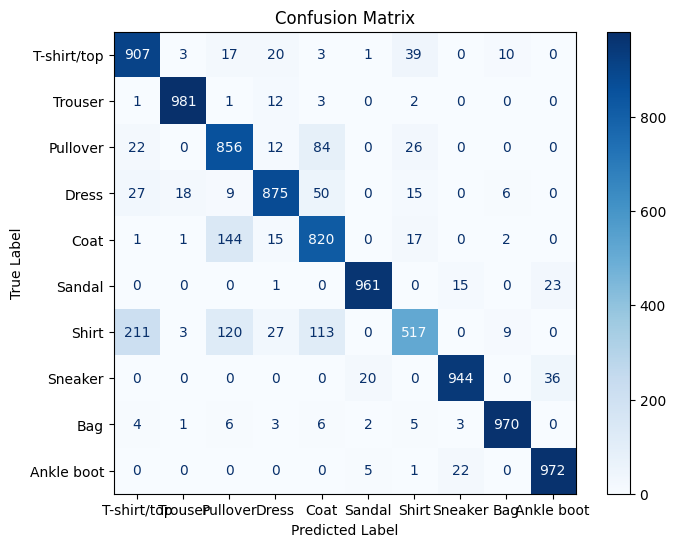

In [42]:
#from the above we got nadam will aceive best accuracy 89.15 for the hyperparameters activation=relu,layer=4,hidden size=128,intialization='xavier',epoch=10,batch_size=32

# Initialize W&B run
wandb.init(project='deep_learning_assignment_1', name='confusion_matrix_run')
theta1=nadam(0.001,0.9,0.99,1e-8,x_train,y_train,x_valid,y_valid,64,3,128,'tanh','softmax','Xavier',0,10)


#Question 7 : The confusion matrix of the best model, for that first i collect theta from the best model and apply forward_prop, from that i get
y_test_label=[]
y_test_pred_label=[]
m=x_test.shape[0]
for i in range(m):
  x_tes =x_test[i,:].reshape(-1,1)
  a,h,y_test_pred=forward_prop(x_tes.T,theta1,'tanh','softmax',3)
  y1=np.argmax(y_test[i,:].reshape(-1,1),axis=0)
  y_test_label.append(y1)
  # Get the index of the maximum probability for the current sample
  y2=np.argmax(y_test_pred)
  # Append only the predicted class label (integer) to the list
  y_test_pred_label.append(y2)
import wandb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt



# Compute confusion matrix
cm = confusion_matrix(y_test_label, y_test_pred_label)
class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
cm_display.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Log the confusion matrix plot to W&B
wandb.log({"Confusion Matrix": wandb.Image(fig)})

# Finish the W&B run
wandb.finish()


In [ ]:
# question 8 : running a all the models for squared error loss and comapre them with previous one

In [ ]:
def main():
  with wandb.init() as run:
    run_name=f"ac-{wandb.config.activation_hidden}_hs-{wandb.config.hidden_size}_epc-{wandb.config.epochs}_nl-{wandb.config.num_layers}_lr{wandb.config.learning_rate}_wd-{wandb.config.weight_decay}_opt-{wandb.config.optimizer}_bs-{wandb.config.batch_size}_wi-{wandb.config.weight_ini_method}"
    wandb.run.name=run_name

    model_training(wandb.config.learning_rate,0.9,0.9,0.99,1e-8,x_train,y_train,x_valid,y_valid,wandb.config.optimizer,wandb.config.batch_size,wandb.config.num_layers,wandb.config.hidden_size,wandb.config.activation_hidden,wandb.config.activation_output,wandb.config.weight_ini_method,wandb.config.weight_decay,wandb.config.epochs,'mse_loss')

try:
    wandb.agent(sweep_id,function=main,count=)
    wandb.finish()
except BrokenPipeError:
    print("Encountered a BrokenPipeError. Attempting to gracefully finish the run.")
    # You can add additional error handling logic here, such as saving intermediate results
    wandb.finish(quiet=True)  # Try finishing quietly to avoid further errors

wandb: Agent Starting Run: xbw7v2vr with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.0826793753722251, Val Loss: 0.0828397645585575
Epoch 2, Train Loss: 0.07496900345762095, Val Loss: 0.07480291456366908
Epoch 3, Train Loss: 0.07387151995515015, Val Loss: 0.07349606482578785
Epoch 4, Train Loss: 0.06838005404065929, Val Loss: 0.06825629561269468
Epoch 5, Train Loss: 0.06762728167201656, Val Loss: 0.06751478115874418
Epoch 6, Train Loss: 0.06410060395608187, Val Loss: 0.0639392353467907
Epoch 7, Train Loss: 0.061751038529186134, Val Loss: 0.06229135646260592
Epoch 8, Train Loss: 0.061596250321579, Val Loss: 0.061926577885176325
Epoch 9, Train Loss: 0.06047981477874228, Val Loss: 0.06093226043167146
Epoch 10, Train Loss: 0.059264561425840925, Val Loss: 0.05993288769484555
Test Accuracy: 44.89


wandb: Agent Starting Run: 28q02ffl with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.18002321409129482, Validation Loss: 0.08671752904207276
Epoch 2, Loss: 0.17966489712617895, Validation Loss: 0.06986406536190089
Epoch 3, Loss: 0.17992728236774166, Validation Loss: 0.06330332912601831
Epoch 4, Loss: 0.1800521849463024, Validation Loss: 0.05972954556769737
Epoch 5, Loss: 0.17972188282468232, Validation Loss: 0.05665564260430892
Epoch 6, Loss: 0.18004881025994315, Validation Loss: 0.05379948473281937
Epoch 7, Loss: 0.17995759170254472, Validation Loss: 0.05319772078653219
Epoch 8, Loss: 0.1799581779650492, Validation Loss: 0.05135001942268513
Epoch 9, Loss: 0.18008725580859936, Validation Loss: 0.051424862447542546
Epoch 10, Loss: 0.17990686187685823, Validation Loss: 0.050134322778374554
Test accuracy: 0.7445


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇▇██
train_loss,▇▁▅▇▂▇▆▆█▅
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,77.16852
train_loss,0.17991
val_accuracy,74.91667
val_loss,0.05013


wandb: Agent Starting Run: hy2hgtwe with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 32, 10]


<ipython-input-8-867b69375f18>:2: RuntimeWarning: overflow encountered in exp
  return 1 /(1 + np.exp(-x))


Epoch 1, Loss: 0.09052478313939143, Validation Loss: 0.09042888932093614
Epoch 2, Loss: 0.0912664738795614, Validation Loss: 0.0913561694341855
Epoch 3, Loss: 0.09095856937893715, Validation Loss: 0.09109280170576751
Epoch 4, Loss: 0.09088705554011528, Validation Loss: 0.09091178350656645
Epoch 5, Loss: 0.09064604223402704, Validation Loss: 0.09063534118371425
Test accuracy: 0.1


epoch,▁▃▅▆█
train_accuracy,▁▇█▁▁
train_loss,▁█▅▄▂
val_accuracy,█▂▁██
val_loss,▁█▆▅▃
epoch,5
train_accuracy,9.97963
train_loss,0.09065
val_accuracy,10.18333
val_loss,0.09064


wandb: Agent Starting Run: ojrxqw8o with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.09000325216477521, Val Loss: 0.090003609603209
Epoch 2, Train Loss: 0.09001619451206118, Val Loss: 0.09000844748929449
Epoch 3, Train Loss: 0.09000534504441114, Val Loss: 0.09000240585890297
Epoch 4, Train Loss: 0.09000832173737999, Val Loss: 0.09000659979417648
Epoch 5, Train Loss: 0.09000389413580262, Val Loss: 0.09001814660241973
Epoch 6, Train Loss: 0.09003505004826902, Val Loss: 0.0900673525865465
Epoch 7, Train Loss: 0.09001234099584994, Val Loss: 0.09002525889350298
Epoch 8, Train Loss: 0.0900016322572873, Val Loss: 0.09000880421388845
Epoch 9, Train Loss: 0.09003438425950469, Val Loss: 0.09001634447359891
Epoch 10, Train Loss: 0.09000682880835725, Val Loss: 0.09000936106881549
Test Accuracy: 10.01


wandb: Agent Starting Run: iekx6zj2 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.025426097947749037, Val Loss: 0.026499889783426475
Epoch 2, Train Loss: 0.017051709385382325, Val Loss: 0.01857879257405009
Epoch 3, Train Loss: 0.016674326406523665, Val Loss: 0.01834457701476395
Epoch 4, Train Loss: 0.014203280298219764, Val Loss: 0.016581691697753965
Epoch 5, Train Loss: 0.013623020821858215, Val Loss: 0.016417504397253254
Epoch 6, Train Loss: 0.01293533127590203, Val Loss: 0.01643537077381714
Epoch 7, Train Loss: 0.012326754130452543, Val Loss: 0.01610404177987172
Epoch 8, Train Loss: 0.015616790658080177, Val Loss: 0.019453922638585704
Epoch 9, Train Loss: 0.011427182304489504, Val Loss: 0.0158512712630786
Epoch 10, Train Loss: 0.011376867794805672, Val Loss: 0.01615541210944254
Test accuracy: 0.8818


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▆▇▇▇█▆██
train_loss,█▄▄▂▂▂▁▃▁▁
val_accuracy,▁▆▆▇█▇█▆██
val_loss,█▃▃▁▁▁▁▃▁▁
epoch,10
train_accuracy,92.04815
train_loss,0.01138
val_accuracy,88.93333
val_loss,0.01616


wandb: Agent Starting Run: g6yenfre with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.0836880424439357, Val Loss: 0.08718668676893038
Epoch 2, Train Loss: 0.07366799992988667, Val Loss: 0.07785845103964933
Epoch 3, Train Loss: 0.06962699814179528, Val Loss: 0.07394833088190643
Epoch 4, Train Loss: 0.0673492410003614, Val Loss: 0.07089362843472599
Epoch 5, Train Loss: 0.06428275946754929, Val Loss: 0.06768409932291955
Test accuracy: 0.674


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,67.85
train_loss,0.06428
val_accuracy,66.15
val_loss,0.06768


wandb: Agent Starting Run: ah9xjgh5 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.04869402997519229, Val Loss: 0.04950716994291966
Epoch 2, Train Loss: 0.042027024913280385, Val Loss: 0.04282798715278827
Epoch 3, Train Loss: 0.03906947472248024, Val Loss: 0.039857740108162086
Epoch 4, Train Loss: 0.03690385677566554, Val Loss: 0.03773413252296914
Epoch 5, Train Loss: 0.03535623272680991, Val Loss: 0.03624122613842856
Test Accuracy: 72.96000000000001


wandb: Agent Starting Run: 6tvcu5y3 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.12535501608781327, Validation Loss: 0.12462452125437985
Epoch 2, Loss: 0.17967580535677066, Validation Loss: 0.17867618128085608
Epoch 3, Loss: 0.17943769545206298, Validation Loss: 0.17843845098124644
Epoch 4, Loss: 0.18006659652238585, Validation Loss: 0.17906664495721247
Epoch 5, Loss: 0.1756086342073978, Validation Loss: 0.17466857314690332
Epoch 6, Loss: 0.17452994856277168, Validation Loss: 0.17355739354421051
Epoch 7, Loss: 0.15904286095209455, Validation Loss: 0.15817646404552044
Epoch 8, Loss: 0.17649266314928883, Validation Loss: 0.17550719950228408
Epoch 9, Loss: 0.12963997882588946, Validation Loss: 0.13009435543984288
Epoch 10, Loss: 0.12506032840034895, Validation Loss: 0.12587828135502926
Test accuracy: 0.1


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▂▁▁▁▁▁▁▁█▄
train_loss,▁███▇▇▅█▂▁
val_accuracy,▇███████▁▅
val_loss,▁███▇▇▅█▂▁
epoch,10
train_accuracy,10.01852
train_loss,0.12506
val_accuracy,9.83333
val_loss,0.12588


wandb: Agent Starting Run: ocybhfqh with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Loss: 0.13197855984223678, Validation Loss: 0.03236009031419731
Epoch 2, Loss: 0.1457310471702668, Validation Loss: 0.026147651829928377
Epoch 3, Loss: 0.1506379400317564, Validation Loss: 0.02376545272405695
Epoch 4, Loss: 0.1534373903355646, Validation Loss: 0.02241711010357468
Epoch 5, Loss: 0.15573884844867228, Validation Loss: 0.021450081014755894
Epoch 6, Loss: 0.1573809404565144, Validation Loss: 0.02135629061627474
Epoch 7, Loss: 0.1582569237039676, Validation Loss: 0.020284663334683428
Epoch 8, Loss: 0.15835839214475525, Validation Loss: 0.01988945936435812
Epoch 9, Loss: 0.1586150347215018, Validation Loss: 0.01975311359216739
Epoch 10, Loss: 0.15967613303503608, Validation Loss: 0.019376952756689207
Test accuracy: 0.8539


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇███
train_loss,▁▄▆▆▇▇████
val_accuracy,▁▄▆▆▇▇████
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
train_accuracy,87.21111
train_loss,0.15968
val_accuracy,86.18333
val_loss,0.01938


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lifoqhku with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.02094182765654463, Val Loss: 0.021765771100858138
Epoch 2, Train Loss: 0.018811741261716107, Val Loss: 0.019781682714973253
Epoch 3, Train Loss: 0.01770261547552147, Val Loss: 0.01908941660936814
Epoch 4, Train Loss: 0.017297830067714105, Val Loss: 0.01910575519769458
Epoch 5, Train Loss: 0.016952187803319797, Val Loss: 0.018870453754110814
Epoch 6, Train Loss: 0.015749124508548363, Val Loss: 0.018219178493155793
Epoch 7, Train Loss: 0.014566190135681506, Val Loss: 0.01696812722177873
Epoch 8, Train Loss: 0.013512969640828055, Val Loss: 0.016785721339266143
Epoch 9, Train Loss: 0.013317261622389196, Val Loss: 0.01669094256742928
Epoch 10, Train Loss: 0.012947501448679727, Val Loss: 0.01659655106119821
Test accuracy: 0.8788


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▄▄▅▆▇██
train_loss,█▆▅▅▅▃▂▁▁▁
val_accuracy,▁▃▅▄▄▅▆▇██
val_loss,█▅▄▄▄▃▂▁▁▁
epoch,10
train_accuracy,91.0463
train_loss,0.01295
val_accuracy,88.61667
val_loss,0.0166


wandb: Agent Starting Run: dtla3aco with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 10]
Epoch 1, Loss: 0.16252877096409524, Validation Loss: 0.02013634281603377
Epoch 2, Loss: 0.16377761761231052, Validation Loss: 0.020012834782029282
Epoch 3, Loss: 0.16211723923992713, Validation Loss: 0.020089958809650775
Epoch 4, Loss: 0.16623614604847686, Validation Loss: 0.018393727860499632
Epoch 5, Loss: 0.16506608800131822, Validation Loss: 0.017265439873486686
Test accuracy: 0.8692


epoch,▁▃▅▆█
train_accuracy,▁▂▃▆█
train_loss,▂▄▁█▆
val_accuracy,▁▂▂▇█
val_loss,███▄▁
epoch,5
train_accuracy,89.42778
train_loss,0.16507
val_accuracy,87.86667
val_loss,0.01727


wandb: Agent Starting Run: 2sn6zjdy with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.15949302671509796, Validation Loss: 0.019940719503337055
Epoch 2, Loss: 0.16206788427138963, Validation Loss: 0.02001565741967632
Epoch 3, Loss: 0.16227671440775346, Validation Loss: 0.01966471445010446
Epoch 4, Loss: 0.1655927413861693, Validation Loss: 0.01766197335311823
Epoch 5, Loss: 0.16483241870941517, Validation Loss: 0.017902906276569194
Test accuracy: 0.872


epoch,▁▃▅▆█
train_accuracy,▁▂▃▆█
train_loss,▁▄▄█▇
val_accuracy,▂▁▃█▇
val_loss,██▇▁▂
epoch,5
train_accuracy,89.58519
train_loss,0.16483
val_accuracy,87.6
val_loss,0.0179


wandb: Agent Starting Run: e79emf75 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 10]
Epoch 1, Loss: 0.18003102852697134, Validation Loss: 0.17962360673091973
Epoch 2, Loss: 0.17929067891369257, Validation Loss: 0.17888619812640238
Epoch 3, Loss: 0.13624561198462917, Validation Loss: 0.13587418365228915
Epoch 4, Loss: 0.17996293863368454, Validation Loss: 0.18033330892170843
Epoch 5, Loss: 0.17695826505327283, Validation Loss: 0.1765452892265663
Epoch 6, Loss: 0.17995185184968526, Validation Loss: 0.18043333333118158
Epoch 7, Loss: 0.17981481481477765, Validation Loss: 0.18166666666662926
Epoch 8, Loss: 0.113413251830141, Validation Loss: 0.11420283019699433
Epoch 9, Loss: 0.17936334855143793, Validation Loss: 0.17858729652115032
Epoch 10, Loss: 0.1799518072049088, Validation Loss: 0.18043328849590443
Test accuracy: 0.1


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▂▂▂▄▂▄█▄▁▄
train_loss,██▃████▁██
val_accuracy,▇▇▇▅▇▅▁▅█▅
val_loss,██▃█▇██▁██
epoch,10
train_accuracy,10.02407
train_loss,0.17995
val_accuracy,9.78333
val_loss,0.18043


wandb: Agent Starting Run: 2jkh0noa with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.08675888358596284, Val Loss: 0.08741961423797055
Epoch 2, Train Loss: 0.07230161728742437, Val Loss: 0.07333667436557162
Epoch 3, Train Loss: 0.06557340537483448, Val Loss: 0.06659979661440407
Epoch 4, Train Loss: 0.061674885459613964, Val Loss: 0.06293839884629893
Epoch 5, Train Loss: 0.05934852269952066, Val Loss: 0.06036651598893087
Test Accuracy: 52.39


wandb: Agent Starting Run: zkprbxft with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.021924985539436195, Val Loss: 0.022752541643788985
Epoch 2, Train Loss: 0.018968267775914698, Val Loss: 0.01991172577348237
Epoch 3, Train Loss: 0.017272754294628462, Val Loss: 0.01867664223144114
Epoch 4, Train Loss: 0.01722774143980869, Val Loss: 0.01915262436673792
Epoch 5, Train Loss: 0.01567187942433088, Val Loss: 0.01765000483175821
Test accuracy: 0.8675


epoch,▁▃▅▆█
train_accuracy,▁▄▆▆█
train_loss,█▅▃▃▁
val_accuracy,▁▅▇▆█
val_loss,█▄▂▃▁
epoch,5
train_accuracy,88.99815
train_loss,0.01567
val_accuracy,87.8
val_loss,0.01765


wandb: Agent Starting Run: 5sy1ywzc with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.04226862598684814, Val Loss: 0.04370125085970933
Epoch 2, Train Loss: 0.04206794567248447, Val Loss: 0.043246230815050093
Epoch 3, Train Loss: 0.03796700438958907, Val Loss: 0.038879404585027755
Epoch 4, Train Loss: 0.03749054594402803, Val Loss: 0.03854097191028777
Epoch 5, Train Loss: 0.035902480149048316, Val Loss: 0.037572229410886546
Epoch 6, Train Loss: 0.03566922732894098, Val Loss: 0.037013001361472786
Epoch 7, Train Loss: 0.04085643847437393, Val Loss: 0.042055717514870895
Epoch 8, Train Loss: 0.03394943504282513, Val Loss: 0.03503490839623018
Epoch 9, Train Loss: 0.03347909529663773, Val Loss: 0.034975829018418815
Epoch 10, Train Loss: 0.031018153447541268, Val Loss: 0.03233067627781283
Test accuracy: 0.7662


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▃▄▅▂▇▆█
train_loss,██▅▅▄▄▇▃▃▁
val_accuracy,▁▃▃▃▄▅▁▇▆█
val_loss,██▅▅▄▄▇▃▃▁
epoch,10
train_accuracy,77.68148
train_loss,0.03102
val_accuracy,76.76667
val_loss,0.03233


wandb: Agent Starting Run: 0e927rsp with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.02153486215319355, Val Loss: 0.022435754952985453
Epoch 2, Train Loss: 0.01774378103835502, Val Loss: 0.019232680002214238
Epoch 3, Train Loss: 0.017510767351214793, Val Loss: 0.019177498615618998
Epoch 4, Train Loss: 0.01563078406060108, Val Loss: 0.01790886198277359
Epoch 5, Train Loss: 0.015397570349923555, Val Loss: 0.017830123418612672
Test accuracy: 0.8663


epoch,▁▃▅▆█
train_accuracy,▁▅▆██
train_loss,█▄▃▁▁
val_accuracy,▁▆▆██
val_loss,█▃▃▁▁
epoch,5
train_accuracy,89.21481
train_loss,0.0154
val_accuracy,87.45
val_loss,0.01783


wandb: Agent Starting Run: 3211tbjz with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.01921285617776834, Val Loss: 0.020262228769102993
Epoch 2, Train Loss: 0.018343787796224288, Val Loss: 0.019637304041461925
Epoch 3, Train Loss: 0.01759230227595161, Val Loss: 0.018959684564901002
Epoch 4, Train Loss: 0.01615567436033847, Val Loss: 0.018279936883877555
Epoch 5, Train Loss: 0.0144864375892241, Val Loss: 0.016867032938025737
Test accuracy: 0.8728


epoch,▁▃▅▆█
train_accuracy,▁▃▄▅█
train_loss,█▇▆▃▁
val_accuracy,▁▃▃▅█
val_loss,█▇▅▄▁
epoch,5
train_accuracy,89.80556
train_loss,0.01449
val_accuracy,88.63333
val_loss,0.01687


wandb: Agent Starting Run: yh08ystd with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.14692734503490357, Validation Loss: 0.6411469311432916
Epoch 2, Loss: 0.15126525168803318, Validation Loss: 0.5649969994614404
Epoch 3, Loss: 0.15338036665484786, Validation Loss: 0.5376249421982972
Epoch 4, Loss: 0.15484047720898408, Validation Loss: 0.5068758587199567
Epoch 5, Loss: 0.15565284843568106, Validation Loss: 0.49127104842042363
Epoch 6, Loss: 0.15719924215622152, Validation Loss: 0.48306518375190366
Epoch 7, Loss: 0.15676746629037233, Validation Loss: 0.47840597653983136
Epoch 8, Loss: 0.15772770342930223, Validation Loss: 0.4641903483311318
Epoch 9, Loss: 0.15851894923615542, Validation Loss: 0.4546053148534458
Epoch 10, Loss: 0.15865927133083163, Validation Loss: 0.4468421324929427
 accuracy: 0.8286


wandb: Agent Starting Run: 9dk9zvn1 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.059823075525469054, Val Loss: 0.06113025850342994
Epoch 2, Train Loss: 0.05096868440583515, Val Loss: 0.05154238254125775
Epoch 3, Train Loss: 0.04277028615869221, Val Loss: 0.04370807954094446
Epoch 4, Train Loss: 0.04431570158643021, Val Loss: 0.04539186839225124
Epoch 5, Train Loss: 0.06005798975648713, Val Loss: 0.060529092793686214
Test accuracy: 0.5263


epoch,▁▃▅▆█
train_accuracy,▃▃▇█▁
train_loss,█▄▁▂█
val_accuracy,▃▄▇█▁
val_loss,█▄▁▂█
epoch,5
train_accuracy,52.78704
train_loss,0.06006
val_accuracy,52.08333
val_loss,0.06053


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9vvxwlcm with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.08973580407070877, Val Loss: 0.08975045305046263
Epoch 2, Train Loss: 0.08945094999631592, Val Loss: 0.08946852634206276
Epoch 3, Train Loss: 0.08909106993200973, Val Loss: 0.08912023145126173
Epoch 4, Train Loss: 0.08857213594581319, Val Loss: 0.08860017263876456
Epoch 5, Train Loss: 0.08774778979024925, Val Loss: 0.08779435042293081
Epoch 6, Train Loss: 0.0863970877509716, Val Loss: 0.08645842249469168
Epoch 7, Train Loss: 0.08408602544233239, Val Loss: 0.08418075871081518
Epoch 8, Train Loss: 0.08063073431341347, Val Loss: 0.08078311261293998
Epoch 9, Train Loss: 0.07646156258607907, Val Loss: 0.07667994350928138
Epoch 10, Train Loss: 0.07254283837750386, Val Loss: 0.07278065533392875
Test Accuracy: 50.32


wandb: Agent Starting Run: l1dtuowf with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.01967321160808731, Val Loss: 0.02094712028696796
Epoch 2, Train Loss: 0.017966966994607873, Val Loss: 0.019357111907980125
Epoch 3, Train Loss: 0.01838034750328821, Val Loss: 0.020786806356504935
Epoch 4, Train Loss: 0.016042716054080478, Val Loss: 0.018653974515640447
Epoch 5, Train Loss: 0.013855206615312907, Val Loss: 0.01697513379971313
Epoch 6, Train Loss: 0.013366757606611003, Val Loss: 0.017083115109143353
Epoch 7, Train Loss: 0.012808875856619013, Val Loss: 0.016913324941998112
Epoch 8, Train Loss: 0.013152446956629149, Val Loss: 0.01757931641054921
Epoch 9, Train Loss: 0.011125865237376503, Val Loss: 0.016225691812045837
Epoch 10, Train Loss: 0.010988983500961495, Val Loss: 0.01568242976959169
Test accuracy: 0.8846


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▂▄▆▆▇▆██
train_loss,█▇▇▅▃▃▂▃▁▁
val_accuracy,▁▃▂▅▆▆▇▅██
val_loss,█▆█▅▃▃▃▄▂▁
epoch,10
train_accuracy,92.22037
train_loss,0.01099
val_accuracy,89.25
val_loss,0.01568


wandb: Agent Starting Run: oomngglv with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.019400405113718953, Val Loss: 0.02048245395424866
Epoch 2, Train Loss: 0.01713517848768843, Val Loss: 0.01857299227846812
Epoch 3, Train Loss: 0.015911058664996564, Val Loss: 0.017811824346449054
Epoch 4, Train Loss: 0.013993237657236477, Val Loss: 0.016452210292880694
Epoch 5, Train Loss: 0.013643546895804772, Val Loss: 0.016150477048810064
Epoch 6, Train Loss: 0.013513075586474986, Val Loss: 0.01671671947402096
Epoch 7, Train Loss: 0.011843248394233813, Val Loss: 0.015651052413107536
Epoch 8, Train Loss: 0.01155175308872502, Val Loss: 0.01615049538613931
Epoch 9, Train Loss: 0.011480017003988608, Val Loss: 0.016240202359246787
Epoch 10, Train Loss: 0.01075944848538, Val Loss: 0.01595115507390142
Test accuracy: 0.8842


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇▇█
train_loss,█▆▅▄▃▃▂▂▂▁
val_accuracy,▁▄▅▆▇▇█▇█▇
val_loss,█▅▄▂▂▃▁▂▂▁
epoch,10
train_accuracy,92.6
train_loss,0.01076
val_accuracy,88.76667
val_loss,0.01595


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5kej6iyn with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Loss: 0.13463285088675783, Validation Loss: 0.032906886169408
Epoch 2, Loss: 0.14931556937285725, Validation Loss: 0.026401337467223278
Epoch 3, Loss: 0.15369129318971225, Validation Loss: 0.02311874463508396
Epoch 4, Loss: 0.15774432608642164, Validation Loss: 0.021198479857582865
Epoch 5, Loss: 0.16028667590260195, Validation Loss: 0.020764633165018885
Test accuracy: 0.8493


epoch,▁▃▅▆█
train_accuracy,▁▄▇██
train_loss,▁▅▆▇█
val_accuracy,▁▄▇██
val_loss,█▄▂▁▁
epoch,5
train_accuracy,86.73519
train_loss,0.16029
val_accuracy,85.6
val_loss,0.02076


wandb: Agent Starting Run: nd4jwlw1 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.03372452613455897, Val Loss: 0.03487913514510839
Epoch 2, Train Loss: 0.025611358752502426, Val Loss: 0.026600490215819724
Epoch 3, Train Loss: 0.022525484119644654, Val Loss: 0.023755194655793562
Epoch 4, Train Loss: 0.020638492877591747, Val Loss: 0.02174399399124132
Epoch 5, Train Loss: 0.01989008971201433, Val Loss: 0.021076976357728778
Epoch 6, Train Loss: 0.019182059047430026, Val Loss: 0.020562172793276427
Epoch 7, Train Loss: 0.018346921062325085, Val Loss: 0.019829167776269377
Epoch 8, Train Loss: 0.01785818471513056, Val Loss: 0.019418881919678603
Epoch 9, Train Loss: 0.017440282839369665, Val Loss: 0.01915852171461736
Epoch 10, Train Loss: 0.017254718021919885, Val Loss: 0.019156209632721344
Test accuracy: 0.8581


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,88.07222
train_loss,0.01725
val_accuracy,86.73333
val_loss,0.01916


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vsp6fnz5 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 10]
Epoch 1, Loss: 0.1724855939674157, Validation Loss: 0.15906026781343657
Epoch 2, Loss: 0.15306578859667805, Validation Loss: 0.1491262041579407
Epoch 3, Loss: 0.17892407658870385, Validation Loss: 0.17863007456112398
Epoch 4, Loss: 0.1797302618129361, Validation Loss: 0.1787322308055252
Epoch 5, Loss: 0.15733038330223464, Validation Loss: 0.15692468826203104
Epoch 6, Loss: 0.15456994281359462, Validation Loss: 0.15492169040461626
Epoch 7, Loss: 0.17925138911429428, Validation Loss: 0.1785510841733834
Epoch 8, Loss: 0.14116919996237598, Validation Loss: 0.1406080735469525
Epoch 9, Loss: 0.1797519051205346, Validation Loss: 0.1816032345837134
Epoch 10, Loss: 0.17988586054550373, Validation Loss: 0.18036730376759863
Test accuracy: 0.1


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▁▁▁▁▁▁▁▁▁
train_loss,▇▃██▄▃█▁██
val_accuracy,█▁▂▂▂▂▂▂▁▁
val_loss,▄▂▇█▄▃▇▁██
epoch,10
train_accuracy,10.02407
train_loss,0.17989
val_accuracy,9.78333
val_loss,0.18037


wandb: Agent Starting Run: 65sn4v0x with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.020363742012777065, Val Loss: 0.021237285206216545
Epoch 2, Train Loss: 0.01879422408276671, Val Loss: 0.020351431876248202
Epoch 3, Train Loss: 0.016853377119216556, Val Loss: 0.0188117711752366
Epoch 4, Train Loss: 0.015702323929295704, Val Loss: 0.017967475962497634
Epoch 5, Train Loss: 0.01592200574143795, Val Loss: 0.018543038158248
Test Accuracy: 86.00999999999999


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6lsbrbuk with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.028280062832082106, Val Loss: 0.028993683756821022
Epoch 2, Train Loss: 0.024535018874534582, Val Loss: 0.02512791942912942
Epoch 3, Train Loss: 0.022861820818019695, Val Loss: 0.02343637692750013
Epoch 4, Train Loss: 0.021905741935964687, Val Loss: 0.02255520358600386
Epoch 5, Train Loss: 0.021287632588634267, Val Loss: 0.021856514838251677
Test Accuracy: 83.65


wandb: Agent Starting Run: 6wj6zva5 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.025498796498607253, Val Loss: 0.02620404337507596
Epoch 2, Train Loss: 0.020762994293273676, Val Loss: 0.021623591931874533
Epoch 3, Train Loss: 0.01933541340549939, Val Loss: 0.020383478648079427
Epoch 4, Train Loss: 0.017677567740419002, Val Loss: 0.018861586900679822
Epoch 5, Train Loss: 0.017909636566724396, Val Loss: 0.01924830072988588
Epoch 6, Train Loss: 0.01794838462528112, Val Loss: 0.019254205815772862
Epoch 7, Train Loss: 0.017442943288216783, Val Loss: 0.01930311258890196
Epoch 8, Train Loss: 0.015873240233682386, Val Loss: 0.017721372269653445
Epoch 9, Train Loss: 0.017092392578783165, Val Loss: 0.019379705259337014
Epoch 10, Train Loss: 0.016001437198976648, Val Loss: 0.018498373609720717
Test accuracy: 0.8622


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▅▇▇▇▇█▇█
train_loss,█▅▄▂▂▃▂▁▂▁
val_accuracy,▁▅▅▇▆▆▆█▆▇
val_loss,█▄▃▂▂▂▂▁▂▂
epoch,10
train_accuracy,88.70556
train_loss,0.016
val_accuracy,87.16667
val_loss,0.0185


wandb: Agent Starting Run: 2e7s1jd6 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.030703827930308507, Val Loss: 0.031786654559186854
Epoch 2, Train Loss: 0.02637733720867672, Val Loss: 0.027470010074178645
Epoch 3, Train Loss: 0.02462483033665985, Val Loss: 0.025841459921202455
Epoch 4, Train Loss: 0.023530235909412226, Val Loss: 0.024782945733767804
Epoch 5, Train Loss: 0.022440233348477185, Val Loss: 0.02426978898231028
Epoch 6, Train Loss: 0.021778977054862814, Val Loss: 0.023566063420547522
Epoch 7, Train Loss: 0.021108817527060095, Val Loss: 0.02313322895909753
Epoch 8, Train Loss: 0.02099667577081971, Val Loss: 0.022861714266964348
Epoch 9, Train Loss: 0.02014999696723962, Val Loss: 0.022467129046877705
Epoch 10, Train Loss: 0.019619717786032092, Val Loss: 0.022193397251629405
Test accuracy: 0.8335


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,86.22778
train_loss,0.01962
val_accuracy,84.5
val_loss,0.02219


wandb: Agent Starting Run: jb6scypn with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.02814843187583602, Val Loss: 0.029382047132523386
Epoch 2, Train Loss: 0.024060378327072068, Val Loss: 0.025731441332781393
Epoch 3, Train Loss: 0.02193885981830049, Val Loss: 0.024167819626830015
Epoch 4, Train Loss: 0.020853342521889487, Val Loss: 0.02383715347738418
Epoch 5, Train Loss: 0.020119238735589486, Val Loss: 0.02315102427888552
Epoch 6, Train Loss: 0.0190636908065289, Val Loss: 0.02260465361038498
Epoch 7, Train Loss: 0.01809298254438605, Val Loss: 0.022192552533622078
Epoch 8, Train Loss: 0.0176181077251856, Val Loss: 0.021911567240724128
Epoch 9, Train Loss: 0.01719180444587475, Val Loss: 0.0217634082279412
Epoch 10, Train Loss: 0.016485754508658915, Val Loss: 0.021282533370537864
Test accuracy: 0.8445


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▅▆▆▇▇██
train_loss,█▆▄▄▃▃▂▂▁▁
val_accuracy,▁▅▅▆▆▇▇███
val_loss,█▅▃▃▃▂▂▂▁▁
epoch,10
train_accuracy,88.36667
train_loss,0.01649
val_accuracy,84.96667
val_loss,0.02128


wandb: Agent Starting Run: at4m2ldy with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.14934817025416003, Validation Loss: 0.03033444805637599
Epoch 2, Loss: 0.15505691197991658, Validation Loss: 0.02667703250571897
Epoch 3, Loss: 0.15794307339765065, Validation Loss: 0.02447305706392511
Epoch 4, Loss: 0.15910144093783357, Validation Loss: 0.023981767368092086
Epoch 5, Loss: 0.160369078589808, Validation Loss: 0.02276390232436238
Test accuracy: 0.8343


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,▁▅▆▇█
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,85.2463
train_loss,0.16037
val_accuracy,84.21667
val_loss,0.02276


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tv17ddsu with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Loss: 0.09038892142750193, Validation Loss: 0.0903444903196418
Epoch 2, Loss: 0.09020239918755736, Validation Loss: 0.09014408391282791
Epoch 3, Loss: 0.09043814648134016, Validation Loss: 0.09056525640084342
Epoch 4, Loss: 0.0902762453374786, Validation Loss: 0.09025016679072308
Epoch 5, Loss: 0.0903436486243412, Validation Loss: 0.0902250869459035
Epoch 6, Loss: 0.09012606555694905, Validation Loss: 0.09008727029191098
Epoch 7, Loss: 0.0902188083506106, Validation Loss: 0.09020041832776668
Epoch 8, Loss: 0.09037316030541487, Validation Loss: 0.09032688092923767
Epoch 9, Loss: 0.09017243547481034, Validation Loss: 0.09011920664667156
Epoch 10, Loss: 0.09012341280554123, Validation Loss: 0.0900771528839132
Test accuracy: 0.1


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▃▃█▁▂▂▂▄▁▄
train_loss,▇▃█▄▆▁▃▇▂▁
val_accuracy,▆▆▁█▇▇▇▅█▅
val_loss,▅▂█▃▃▁▃▅▂▁
epoch,10
train_accuracy,10.01852
train_loss,0.09012
val_accuracy,9.83333
val_loss,0.09008


wandb: Agent Starting Run: yp3ut563 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 10]
Epoch 1, Loss: 0.15535173885977527, Validation Loss: 0.025557933335534095
Epoch 2, Loss: 0.15672318739770422, Validation Loss: 0.022398006943027685
Epoch 3, Loss: 0.1588526212826964, Validation Loss: 0.02080227662625705
Epoch 4, Loss: 0.16112924540792498, Validation Loss: 0.020170234576765204
Epoch 5, Loss: 0.1610469078534225, Validation Loss: 0.019261451660167638
Epoch 6, Loss: 0.16320910764973598, Validation Loss: 0.01877100250241228
Epoch 7, Loss: 0.16371028276344568, Validation Loss: 0.01816949092702936
Epoch 8, Loss: 0.16299000684856357, Validation Loss: 0.018346775059281617
Epoch 9, Loss: 0.163748043024429, Validation Loss: 0.01816989703460286
Epoch 10, Loss: 0.16371415406860285, Validation Loss: 0.018382180048433883
Test accuracy: 0.8608


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇████
train_loss,▁▂▄▆▆██▇██
val_accuracy,▁▃▅▆▇▇████
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
train_accuracy,88.38333
train_loss,0.16371
val_accuracy,87.45
val_loss,0.01838


wandb: Agent Starting Run: a0waanyh with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.05305794752959299, Val Loss: 0.0547055421432119
Epoch 2, Train Loss: 0.04467219932713539, Val Loss: 0.04609151346799834
Epoch 3, Train Loss: 0.04078690694856481, Val Loss: 0.04208422446496078
Epoch 4, Train Loss: 0.03813949813553586, Val Loss: 0.03961930510429734
Epoch 5, Train Loss: 0.03663800521914711, Val Loss: 0.03803282740562549
Epoch 6, Train Loss: 0.03516267847529188, Val Loss: 0.03693161390079052
Epoch 7, Train Loss: 0.03384884612468231, Val Loss: 0.03584333853911485
Epoch 8, Train Loss: 0.033109969272709705, Val Loss: 0.03515002140058142
Epoch 9, Train Loss: 0.032174697068478184, Val Loss: 0.03410533200772146
Epoch 10, Train Loss: 0.031617655243515196, Val Loss: 0.03389261380116153
Test accuracy: 0.7522


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▇▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,77.36481
train_loss,0.03162
val_accuracy,75.66667
val_loss,0.03389


wandb: Agent Starting Run: 7ir2j816 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 10]
Epoch 1, Loss: 0.13839949892023873, Validation Loss: 0.13850685263737103
Epoch 2, Loss: 0.17301978951148647, Validation Loss: 0.17278858078980872
Epoch 3, Loss: 0.179407342299911, Validation Loss: 0.1791159257118939
Epoch 4, Loss: 0.17262057504059022, Validation Loss: 0.1729847783777505
Epoch 5, Loss: 0.12613345616807242, Validation Loss: 0.12598973918917342
Epoch 6, Loss: 0.1498961641278722, Validation Loss: 0.1492650269278199
Epoch 7, Loss: 0.17905995570703748, Validation Loss: 0.178761453331121
Epoch 8, Loss: 0.148765808236469, Validation Loss: 0.1485464845423385
Epoch 9, Loss: 0.12420299077126075, Validation Loss: 0.12452376564002769
Epoch 10, Loss: 0.11748205805325711, Validation Loss: 0.11776312650818457
Test accuracy: 0.1


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁███▇▇████
train_loss,▃▇█▇▂▅█▅▂▁
val_accuracy,▁▅▅▁▆█▅▅▃▅
val_loss,▃▇█▇▂▅█▅▂▁
epoch,10
train_accuracy,9.98519
train_loss,0.11748
val_accuracy,10.13333
val_loss,0.11776


wandb: Agent Starting Run: zpxpwj12 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 32, 10]


<ipython-input-8-867b69375f18>:20: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x,axis=1,keepdims=True)


Epoch 1, Loss: nan, Validation Loss: nan
Epoch 2, Loss: nan, Validation Loss: nan
Epoch 3, Loss: nan, Validation Loss: nan
Epoch 4, Loss: nan, Validation Loss: nan
Epoch 5, Loss: nan, Validation Loss: nan
Epoch 6, Loss: nan, Validation Loss: nan
Epoch 7, Loss: nan, Validation Loss: nan
Epoch 8, Loss: nan, Validation Loss: nan
Epoch 9, Loss: nan, Validation Loss: nan
Epoch 10, Loss: nan, Validation Loss: nan
Test accuracy: 0.1


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,10.00556
train_loss,nan
val_accuracy,9.95
val_loss,nan


wandb: Agent Starting Run: 9qy5zzua with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.023402130635453666, Val Loss: 0.024311250978709616
Epoch 2, Train Loss: 0.019367591084905864, Val Loss: 0.02033448946067587
Epoch 3, Train Loss: 0.01850376414114034, Val Loss: 0.01975258638269242
Epoch 4, Train Loss: 0.01752157922956936, Val Loss: 0.01937060598017987
Epoch 5, Train Loss: 0.0162542151113874, Val Loss: 0.0183001566685873
Test accuracy: 0.8635


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▆▆▇█
val_loss,█▃▃▂▁
epoch,5
train_accuracy,88.67037
train_loss,0.01625
val_accuracy,87.36667
val_loss,0.0183


wandb: Agent Starting Run: nzabznsc with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.03153371378769183, Val Loss: 0.03232628952685628
Epoch 2, Train Loss: 0.027623224974935887, Val Loss: 0.02838053815375849
Epoch 3, Train Loss: 0.025538083684963676, Val Loss: 0.026922720660781628
Epoch 4, Train Loss: 0.024418083938117775, Val Loss: 0.025999338489116557
Epoch 5, Train Loss: 0.023685929419030652, Val Loss: 0.025412236601029297
Epoch 6, Train Loss: 0.02288049201540435, Val Loss: 0.024828397066276174
Epoch 7, Train Loss: 0.022285739398344044, Val Loss: 0.02425477320132096
Epoch 8, Train Loss: 0.021625764767441387, Val Loss: 0.023754696799432748
Epoch 9, Train Loss: 0.021334646623412824, Val Loss: 0.02350316100020739
Epoch 10, Train Loss: 0.021015176657537726, Val Loss: 0.022974497485068315
Test accuracy: 0.8281


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,85.15556
train_loss,0.02102
val_accuracy,83.78333
val_loss,0.02297


wandb: Agent Starting Run: sok4znvh with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.12496333735049983, Validation Loss: 0.91768380945845
Epoch 2, Loss: 0.13652955215540094, Validation Loss: 0.7005063410632925
Epoch 3, Loss: 0.14865221676925458, Validation Loss: 0.5189934410091203
Epoch 4, Loss: 0.15511243515238576, Validation Loss: 0.4558383029617519
Epoch 5, Loss: 0.15622939042610665, Validation Loss: 0.4293738441698732
Epoch 6, Loss: 0.15780663306761541, Validation Loss: 0.4056539057177651
Epoch 7, Loss: 0.15978209124026563, Validation Loss: 0.4283074478111444
Epoch 8, Loss: 0.1605777948930568, Validation Loss: 0.4054496005621632
Epoch 9, Loss: 0.16142938055545672, Validation Loss: 0.3873139468634437
Epoch 10, Loss: 0.16132195482723394, Validation Loss: 0.37938014327349945
 accuracy: 0.8616


In [ ]:
#Q 10 : download the mnist dataset and run this data set of three recomendation of best models obtain after hyper parameter search.


In [ ]:
from keras.datasets import mnist
(train_x1,train_y1),(test_x1,test_y1)=mnist.load_data()

x1_train,y1_train,x1_val,y1_val,x1_test,y_test=tranform_dataset(train_x1,train_y1,test_x1,test_y1)

In [ ]:
#  optimizer redefined for recommendation and see the accuracy (code is almost same as before only here i remove the wandb log)
def re_mgd(lr, momentum, x_train, y_train, x_val, y_val,x_test,y_test, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)
    train_loss_history = []
    val_loss_history = []

    # Initialize velocity terms for weights and biases
    velocity = {}
    for i in range(1, num_layers + 2):
        velocity[f'W{i}'] = np.zeros_like(theta[f'W{i}'])
        velocity[f'b{i}'] = np.zeros_like(theta[f'b{i}'])

    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        # Mini-batch training
        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers)

            # Update weights and biases using momentum
            for j in range(1, num_layers + 2):
                velocity[f'W{j}'] = momentum * velocity[f'W{j}'] + grad[f'W{j}']
                velocity[f'b{j}'] = momentum * velocity[f'b{j}'] + grad[f'b{j}']

                theta[f'W{j}'] -= lr * (velocity[f'W{j}'] + weight_decay * theta[f'W{j}'])
                theta[f'b{j}'] -= lr * velocity[f'b{j}']

        # Compute the train accuracy
        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store training loss
        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        train_loss_history.append(train_loss)

        # Compute the validation accuracy
        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss},Validation acuuracy:{validation_accuracy}")


    test_accuracy=cal_accuracy(x_test,y_test,theta,active_fun_hidden,active_fun_output,num_layers)
    print(f'Validation accuracy: {validation_accuracy*100}')
    return theta

def re_adam(lr, beta1, beta2, epsilon, x_train, y_train, x_val, y_val,x_test,y_test, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)
    train_loss_history = []
    val_loss_history = []

    # Initialize first moment (m) and second moment (v) dictionaries with zeros
    m = {key: np.zeros_like(theta[key]) for key in theta.keys()}
    v = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    for epoch in range(1, epochs + 1):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients using backpropagation
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers)

            # Update first and second moment estimates and parameters with Adam
            for k in range(1, num_layers + 2):
                m[f'W{k}'] = beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']
                m[f'b{k}'] = beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']

                v[f'W{k}'] = beta2 * v[f'W{k}'] + (1 - beta2) * (grad[f'W{k}'] ** 2)
                v[f'b{k}'] = beta2 * v[f'b{k}'] + (1 - beta2) * (grad[f'b{k}'] ** 2)

                m_hat_W = m[f'W{k}'] / (1 - beta1 ** epoch)
                m_hat_b = m[f'b{k}'] / (1 - beta1 ** epoch)
                v_hat_W = v[f'W{k}'] / (1 - beta2 ** epoch)
                v_hat_b = v[f'b{k}'] / (1 - beta2 ** epoch)

                theta[f'W{k}'] -= lr * (m_hat_W / (np.sqrt(v_hat_W) + epsilon) + weight_decay * theta[f'W{k}'])
                theta[f'b{k}'] -= lr * m_hat_b / (np.sqrt(v_hat_b) + epsilon)

        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        train_loss_history.append(train_loss)

        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss},Validation acuuracy:{validation_accuracy}")
    test_accuracy=cal_accuracy(x_test,y_test,theta,active_fun_hidden,active_fun_output,num_layers)
    print(f'Validation accuracy: {validation_accuracy*100}')
    return theta



def re_nadam(lr, beta1, beta2, epsilon, x, y, x_val, y_val,x_test,y_test, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay,epochs,loss_function='cross_entropy'):
    # Initialize network parameters
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)

    # Initialize first moment (m) and second moment (v) dictionaries with zeros
    m = {key: np.zeros_like(theta[key]) for key in theta.keys()}
    v = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    # Lists to store loss history
    loss_history = []
    val_loss_history = []

    # Training loop over epochs
    for epoch in range(1, epochs + 1):
        # Shuffle training data
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]

        for i in range(0, x.shape[0], batch_size):
            x_batch = x[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            # Compute gradients using backpropagation
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers)

            # Update first and second moment estimates and parameters with Nadam
            for k in range(1, num_layers + 2):
                # Update biased first moment estimate
                m[f'W{k}'] = beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']
                m[f'b{k}'] = beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']

                # Update biased second moment estimate
                v[f'W{k}'] = beta2 * v[f'W{k}'] + (1 - beta2) * (grad[f'W{k}'] ** 2)
                v[f'b{k}'] = beta2 * v[f'b{k}'] + (1 - beta2) * (grad[f'b{k}'] ** 2)

                # Compute bias-corrected first and second moment estimates with Nesterov acceleration
                m_hat_W = (beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']) / (1 - beta1 ** epoch)
                m_hat_b = (beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']) / (1 - beta1 ** epoch)
                v_hat_W = v[f'W{k}'] / (1 - beta2 ** epoch)
                v_hat_b = v[f'b{k}'] / (1 - beta2 ** epoch)

                # Update weights and biases
                theta[f'W{k}'] -= lr*(m_hat_W / (np.sqrt(v_hat_W) + epsilon) + weight_decay * theta[f'W{k}'])
                theta[f'b{k}'] -= lr * m_hat_b / (np.sqrt(v_hat_b) + epsilon)

        #compute the train accuracy
        train_accuracy=cal_accuracy(x_train,y_train,theta,active_fun_hidden,active_fun_output,num_layers)

        # Compute training loss and predictions
        _, _, y_pred = forward_prop(x, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_pred)
        loss_history.append(train_loss)

        #compute the validation accuracy
        validation_accuracy=cal_accuracy(x_val,y_val,theta,active_fun_hidden,active_fun_output,num_layers)


        # Compute validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        # Print loss for monitoring
        print(f"Epoch {epoch}, Loss: {train_loss}, Validation Loss: {val_loss},Validation acuuracy:{validation_accuracy}")

    test_accuracy=cal_accuracy(x_test,y_test,theta,active_fun_hidden,active_fun_output,num_layers)
    print(f'Training accuracy: {train_accuracy*100}')
    print(f'Validation accuracy: {validation_accuracy*100}')

    return theta




In [ ]:
#1st recomendation

theta=re_nadam(0.001,0.9,0.99,1e-8,x1_train,y1_train,x1_val,y1_val,64,5,64,'relu','softmax','Xavier',0,10)

[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Loss: 8.976133395654726, Validation Loss: 0.1511022798055648,Validation acuuracy:0.9558333333333333
Epoch 2, Loss: 10.641843708560577, Validation Loss: 0.1054675573068786,Validation acuuracy:0.9678333333333333
Epoch 3, Loss: 11.612914306729044, Validation Loss: 0.11063386202052453,Validation acuuracy:0.9651666666666666
Epoch 4, Loss: 12.07860528743294, Validation Loss: 0.08969206395331672,Validation acuuracy:0.975
Epoch 5, Loss: 13.668289047061473, Validation Loss: 0.09347032927661313,Validation acuuracy:0.973
Epoch 6, Loss: 14.64050957065347, Validation Loss: 0.09285336203942426,Validation acuuracy:0.9745
Epoch 7, Loss: 15.046985384588792, Validation Loss: 0.0971923258737286,Validation acuuracy:0.974
Epoch 8, Loss: 16.201484170310092, Validation Loss: 0.10434700643875086,Validation acuuracy:0.9733333333333334
Epoch 9, Loss: 16.658498151544794, Validation Loss: 0.10002283921119488,Validation acuuracy:0.9741666666666666
Epoch 10, Loss: 18.295472926

In [ ]:
#2nd recomendation

theta=re_adam(0.001,0.9,0.99,1e-8,x1_train,y1_train,x1_val,y1_val,64,5,64,'relu','softmax','Xavier',0,10)

[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.1293963317743927, Val Loss: 0.14559807296171165,Validation acuuracy:0.9575
Epoch 2, Train Loss: 0.08594499051578319, Val Loss: 0.11275851221430186,Validation acuuracy:0.9636666666666667
Epoch 3, Train Loss: 0.07821153001438139, Val Loss: 0.11336739258249706,Validation acuuracy:0.9655
Epoch 4, Train Loss: 0.05094498462011537, Val Loss: 0.09568946625128905,Validation acuuracy:0.9725
Epoch 5, Train Loss: 0.04582583829057265, Val Loss: 0.09241338048542128,Validation acuuracy:0.9738333333333333
Epoch 6, Train Loss: 0.041696247234120624, Val Loss: 0.09840150260994136,Validation acuuracy:0.9706666666666667
Epoch 7, Train Loss: 0.02585241605081825, Val Loss: 0.08652995392276348,Validation acuuracy:0.9755
Epoch 8, Train Loss: 0.022948746316367414, Val Loss: 0.09531410693932017,Validation acuuracy:0.9748333333333333
Epoch 9, Train Loss: 0.023371997564286984, Val Loss: 0.09924389480317719,Validation acuuracy:0.9743333333333334
Epoch 10, Train L

In [ ]:
#3rd recomendation

theta=re_mgd(0.001,0.9,x1_train,y1_train,x1_val,y1_val,32,5,32,'relu','softmax','Xavier',0,10)

[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.25193830441955956, Val Loss: 0.2628768819530346,Validation acuuracy:0.9298333333333333
Epoch 2, Train Loss: 0.18896075955956018, Val Loss: 0.21421743302177948,Validation acuuracy:0.943
Epoch 3, Train Loss: 0.16750097690447072, Val Loss: 0.18984333279095486,Validation acuuracy:0.9485
Epoch 4, Train Loss: 0.13857200435470787, Val Loss: 0.16109399679612568,Validation acuuracy:0.9558333333333333
Epoch 5, Train Loss: 0.11976370778902135, Val Loss: 0.15592522664790662,Validation acuuracy:0.9593333333333334
Epoch 6, Train Loss: 0.12388340639031327, Val Loss: 0.16729131457503313,Validation acuuracy:0.9565
Epoch 7, Train Loss: 0.11329036697525828, Val Loss: 0.14602631484105363,Validation acuuracy:0.9588333333333333
Epoch 8, Train Loss: 0.12388561520271561, Val Loss: 0.15866931001404638,Validation acuuracy:0.96
Epoch 9, Train Loss: 0.12066509480264347, Val Loss: 0.17031282761583386,Validation acuuracy:0.9561666666666667
Epoch 10, Train Loss: 0